This script will
- Get data from stations
- Get processed altimeter data
- Plot data location
- Plot time series altimeter and station
- Calculate and Plot accuracies
- Separate low level from high levels

In [1]:
from ground_data import GroundObservations
import geopandas as gpd
import platform
from ts_preprocesing import *#get_date_time_cols
from ts_plots import *
import scipy.interpolate as sc
import geopandas as gpd
from timezonefinder import TimezoneFinder
from icecream import ic
from ts_preprocesing import convert_units
import importlib
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pytz
from pytz import timezone
import timeit
from datetime import datetime
import ipywidgets as widgets 
utc=pytz.utc
utc.zone
%reload_ext autoreload
%autoreload 2

In [2]:
#Entre the date of the files 
txt=widgets.Text(
    value='Format: %Y%m%d_%H_%M',
    placeholder='Add the file posfix',
    description='File prefix:',
    disabled=False
)

btn=widgets.Button(
    description='Add time of figure',
    disabled=False
)

# box=VBox([txt,btn])
display(txt, btn)


Text(value='Format: %Y%m%d_%H_%M', description='File prefix:', placeholder='Add the file posfix')

Button(description='Add time of figure', style=ButtonStyle())

In [3]:
print(txt.value)

20221210_12_18


In [4]:
time_fig=  txt.value#"%Y%m%d_%H_%M"
df_final_ground=pd.read_csv('../data/results/preprossed_ground_data_'+time_fig+'.csv', sep=',', low_memory=False, parse_dates=['date'])
df_final_altis=pd.read_csv('../data/results/preprossed_altis_data_'+time_fig+'.csv', sep=',',low_memory=False, parse_dates=['date'])

In [659]:


#If data if taken in other computer you can use data_preprocessed.csv

df_ground_ts=pd.read_csv('../data/results/data_preprocessed.csv', sep=',', low_memory=False, parse_dates=['date'])
##Option 1..To Slow
# df_ground_ts['doy']=[pd.Period(x, freq='D').dayofyear for x in df_ground_ts['date']]
# df_ground_ts['doy']

#Option 2 if date is datetime 
#df_ground_ts['doy']=df_ground_ts['date'].dt.dayofyear



In [35]:
# df_ground_ts.loc[df_ground_ts['gauge_id']=='RLH2']

In [30]:
# vals=['AUB2', 'BAB2', 'BAN2', 'BJB2', 'BOB2', 'CBB2', 'DRB2', 'DTB2',
#        'DUB2', 'GAB2', 'HHB2', 'HKB2', 'HLB2', 'JNN2', 'KPB2', 'MEB2',
#        'NBB2', 'NHB2', 'NPH2', 'PGH2', 'PLH2', 'PYB2', 'RRV2', 'SAN2',
#        'SKB2', 'TAB2', 'TLB2', 'UBB2']
# df_ground_ts.loc[df_ground_ts['gauge_id'].isin(vals), 'gauge_id'].unique()

In [20]:
# df_ground_ts.gauge_id.unique()


set manually Bangladesh lakes


In [661]:
# df_ground_ts_org=df_ground_ts.copy()

In [24]:
#To save and prevent problem of reading from windows
# df_ground_ts.to_csv('../data/results/data_preprocessed.csv', sep=',')

In [42]:
# df_final_altis=pd.DataFrame()
# df_final_ground=pd.DataFrame()
# df_cm=pd.DataFrame()

In [5]:
#Creating paper group of lakes

#locss lakes
locss_g=df_final_altis.loc[df_final_altis['source']=='LOCSS', 'gauge_id'].unique()
#ARHN and USGS
off_nat_g=df_final_altis.loc[(df_final_altis['source']=='ARHN')|(df_final_altis['source']=='USGS'), 'gauge_id'].unique()
# Reservoirs
res_g=df_final_altis.loc[df_final_altis['source']=='RVBR', 'gauge_id'].unique()
dic_groups={'LOCSS':locss_g,'OFNAT':off_nat_g,'RVBR':res_g}


In [7]:
res_g

array(['12056', '12036', '19069', '12327', '12030', '19126', '19060'],
      dtype=object)

In [6]:
# dic_groups={'LOCSS':locss_g,'OFNAT':off_nat_g,'RVBR':res_g}
# df=df_final_altis.loc[df_final_altis['gauge_id'].isin(dic_groups['LOCSS'])].copy()
# row_f=4
# col_f=4
# w=30
# h=20

# df=df_final_altis.loc[df_final_altis['gauge_id'].isin(dic_groups['OFNAT'])].copy()
# row_f=3
# col_f=4
# w=30
# h=20

# df=df_final_altis.loc[df_final_altis['gauge_id'].isin(dic_groups['RVBR'])].copy()
# row_f=3
# col_f=4
# w=30
# h=20

df=df_final_altis.copy()
row_f=8
col_f=5
w=30
h=20

In [ ]:
# i=0
# j=0

# # this_source='LOCSS'
# fig, axs=plt.subplots(row_f,col_f, figsize=(w,h), sharey=False)
# ymin=-1
# ymax=4
# x_data='val_cd_d_5' #Closest
# y_data='median_d_5' #median between the values


# # df=df_final_altis.copy()

# # categories = np.unique(df[catcol])
# # colors = np.linspace(0, 1, len(categories))
# # colordict = dict(zip(categories, colors))  

# # df["Color"] = df[catcol].apply(lambda x: colordict[x])
# df['gauge_altis']=df.gauge_id +'_'+df.name_altis
# df=df.sort_values(by='lake_name')
# for om in df['gauge_altis'].unique():
#     df_val=df.loc[df['gauge_altis']==om]
#     labelg='ID st: '+df_val['gauge_id'].iloc[0]+' | '+'lake name: '+df_val['lake_name'].iloc[0]+\
#             ' \nOrbit: '+om
#     # ic(labelg)
#     # df_metrics=df_cm.loc[df_cm['altis']==om]
#     # ic(df_metrics)
#     # error_m_text='lake = '+df_metrics['lake_name'].iloc[0]+'\n($R$ = '+str(np.round(df_metrics['R'].iloc[0], decimals=2))+' | '+\
#     #    '$\\rho$ = '+str(np.round(df_metrics['RHO'].iloc[0],decimals=2))+' | n = '+str(df_metrics['n_obs'].iloc[0])+')'#+\
#     # df_final_ground.columns
#     # fig, ax = plt.subplots()
#     # plt.subplot(row_f,col_f,nfig)
#     #Observed Vs Estimates
    
#     axs[i][j].scatter(df_val[x_data],df_val[y_data])#, linestyle=None, marker='o')
#     # plt.ylim(ymin,ymax)
    
#     # plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal places 
#     lims = [
#         np.min([axs[i][j].get_xlim(), axs[i][j].get_ylim()]),  # min of both axes
#         np.max([axs[i][j].get_xlim(), axs[i][j].get_ylim()]),  # max of both axes
#     ]

#     # now plot both limits against eachother
#     axs[i][j].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    
#     # axs[i][j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#     # for label in axs[i][j].get_xticklabels(which='major'):
#     #     label.set(rotation=45, horizontalalignment='right', fontsize=12)
#     # for ylabel in axs[i][j].get_yticklabels(which='major'):
#     #     ylabel.set(fontsize=12)
#     fig.tight_layout(h_pad=3, w_pad=1)
    
#     axs[i][j].set_title(label=labelg, fontdict={'fontsize':14,  'fontweight':'bold'})
#     # axs[i][j].text(0.7,0.2,error_m_text, fontsize=14,weight='bold',
#     #                horizontalalignment='center', verticalalignment='center', transform=axs[i][j].transAxes)
#     if j>=col_f-1:
#         j=0
#         if i<=row_f-1:
#             i=i+1
#     else:
#         j=j+1
# # df_final_altis[['val_cd_d_5','median_d_5']]

'Lake Phelps'

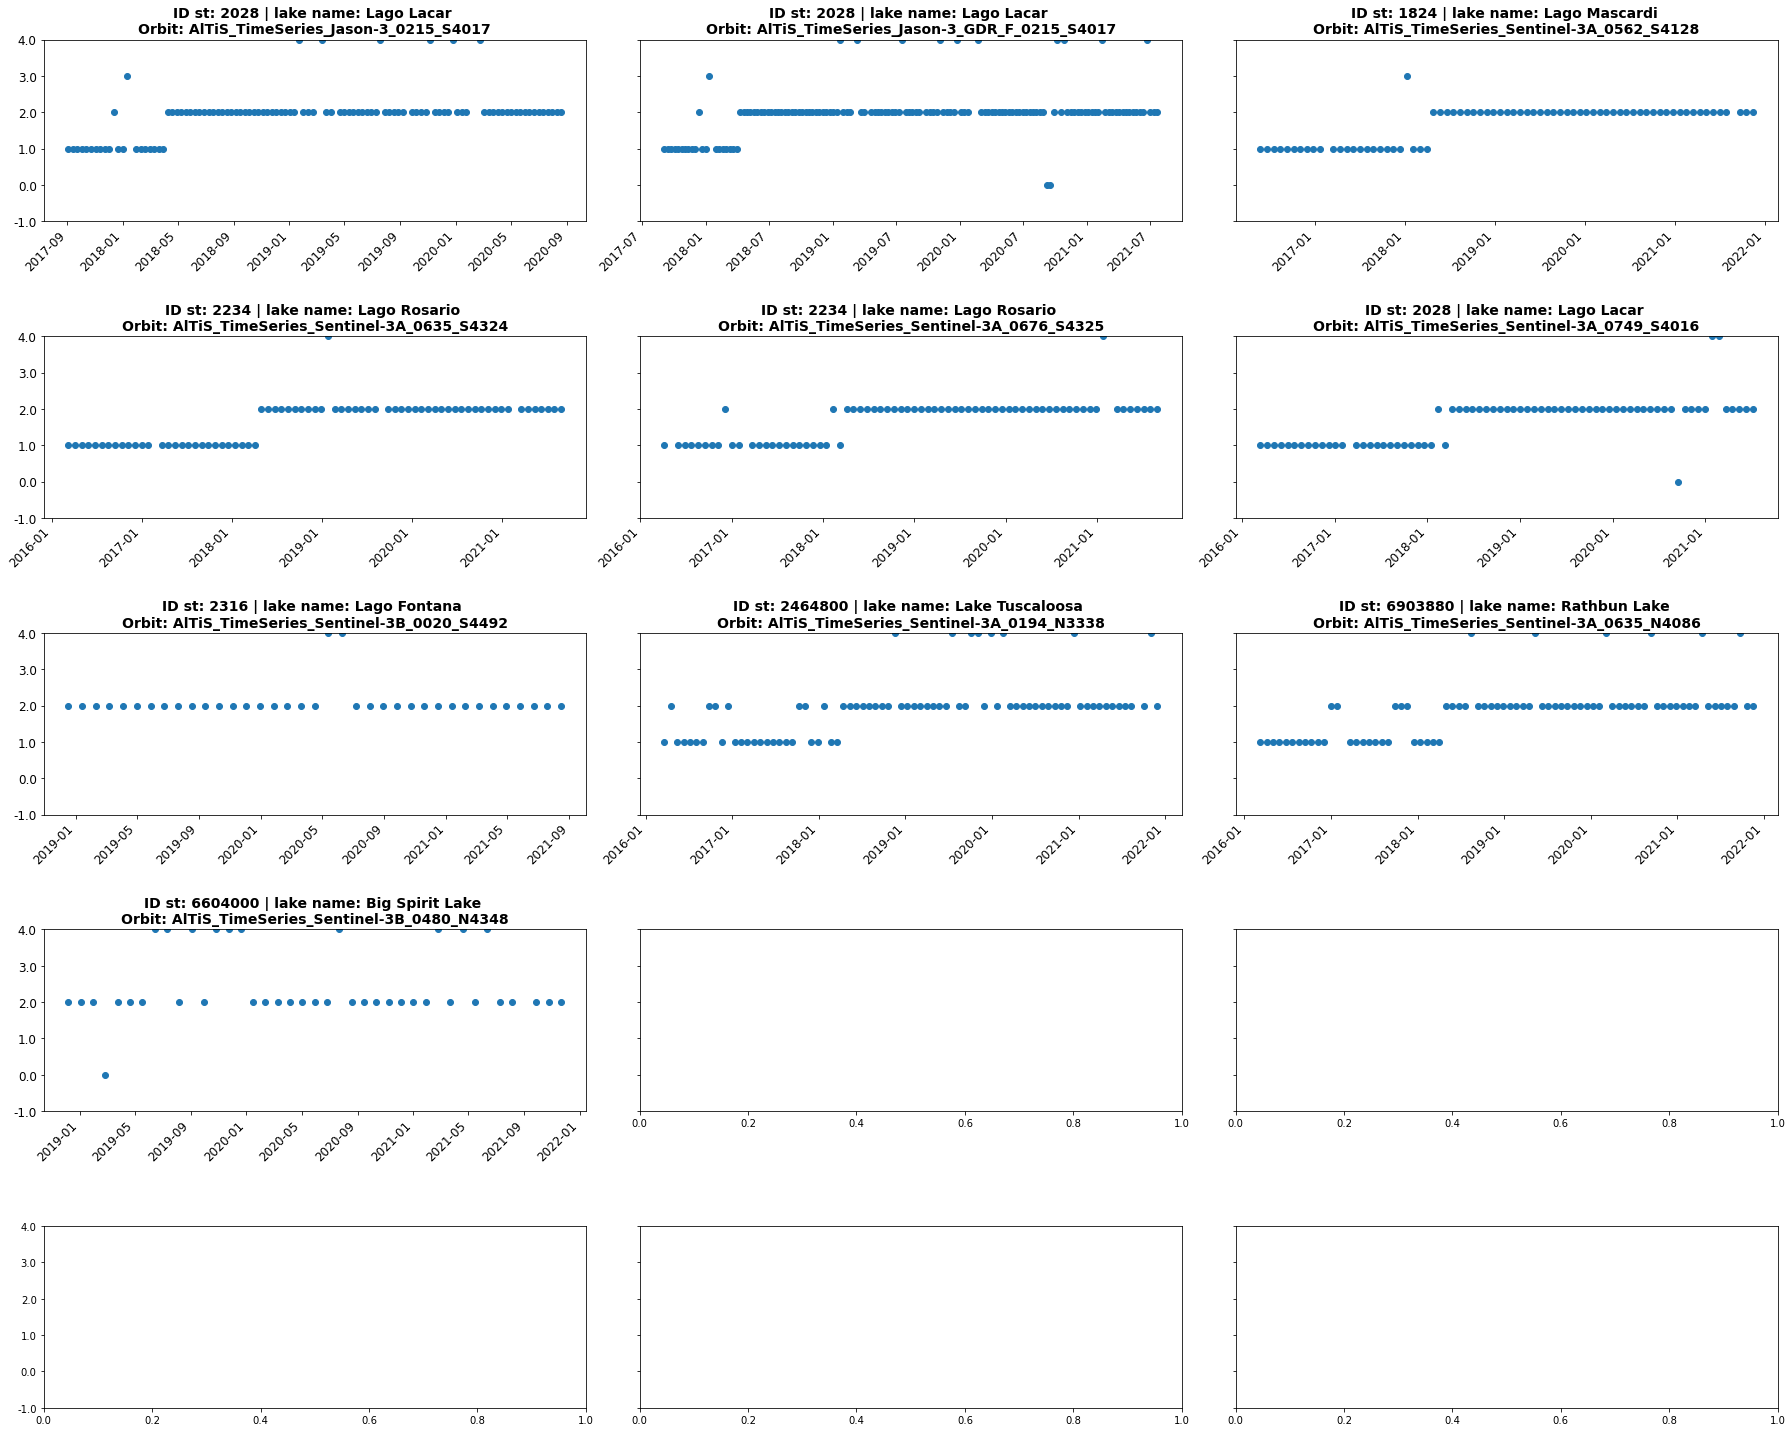

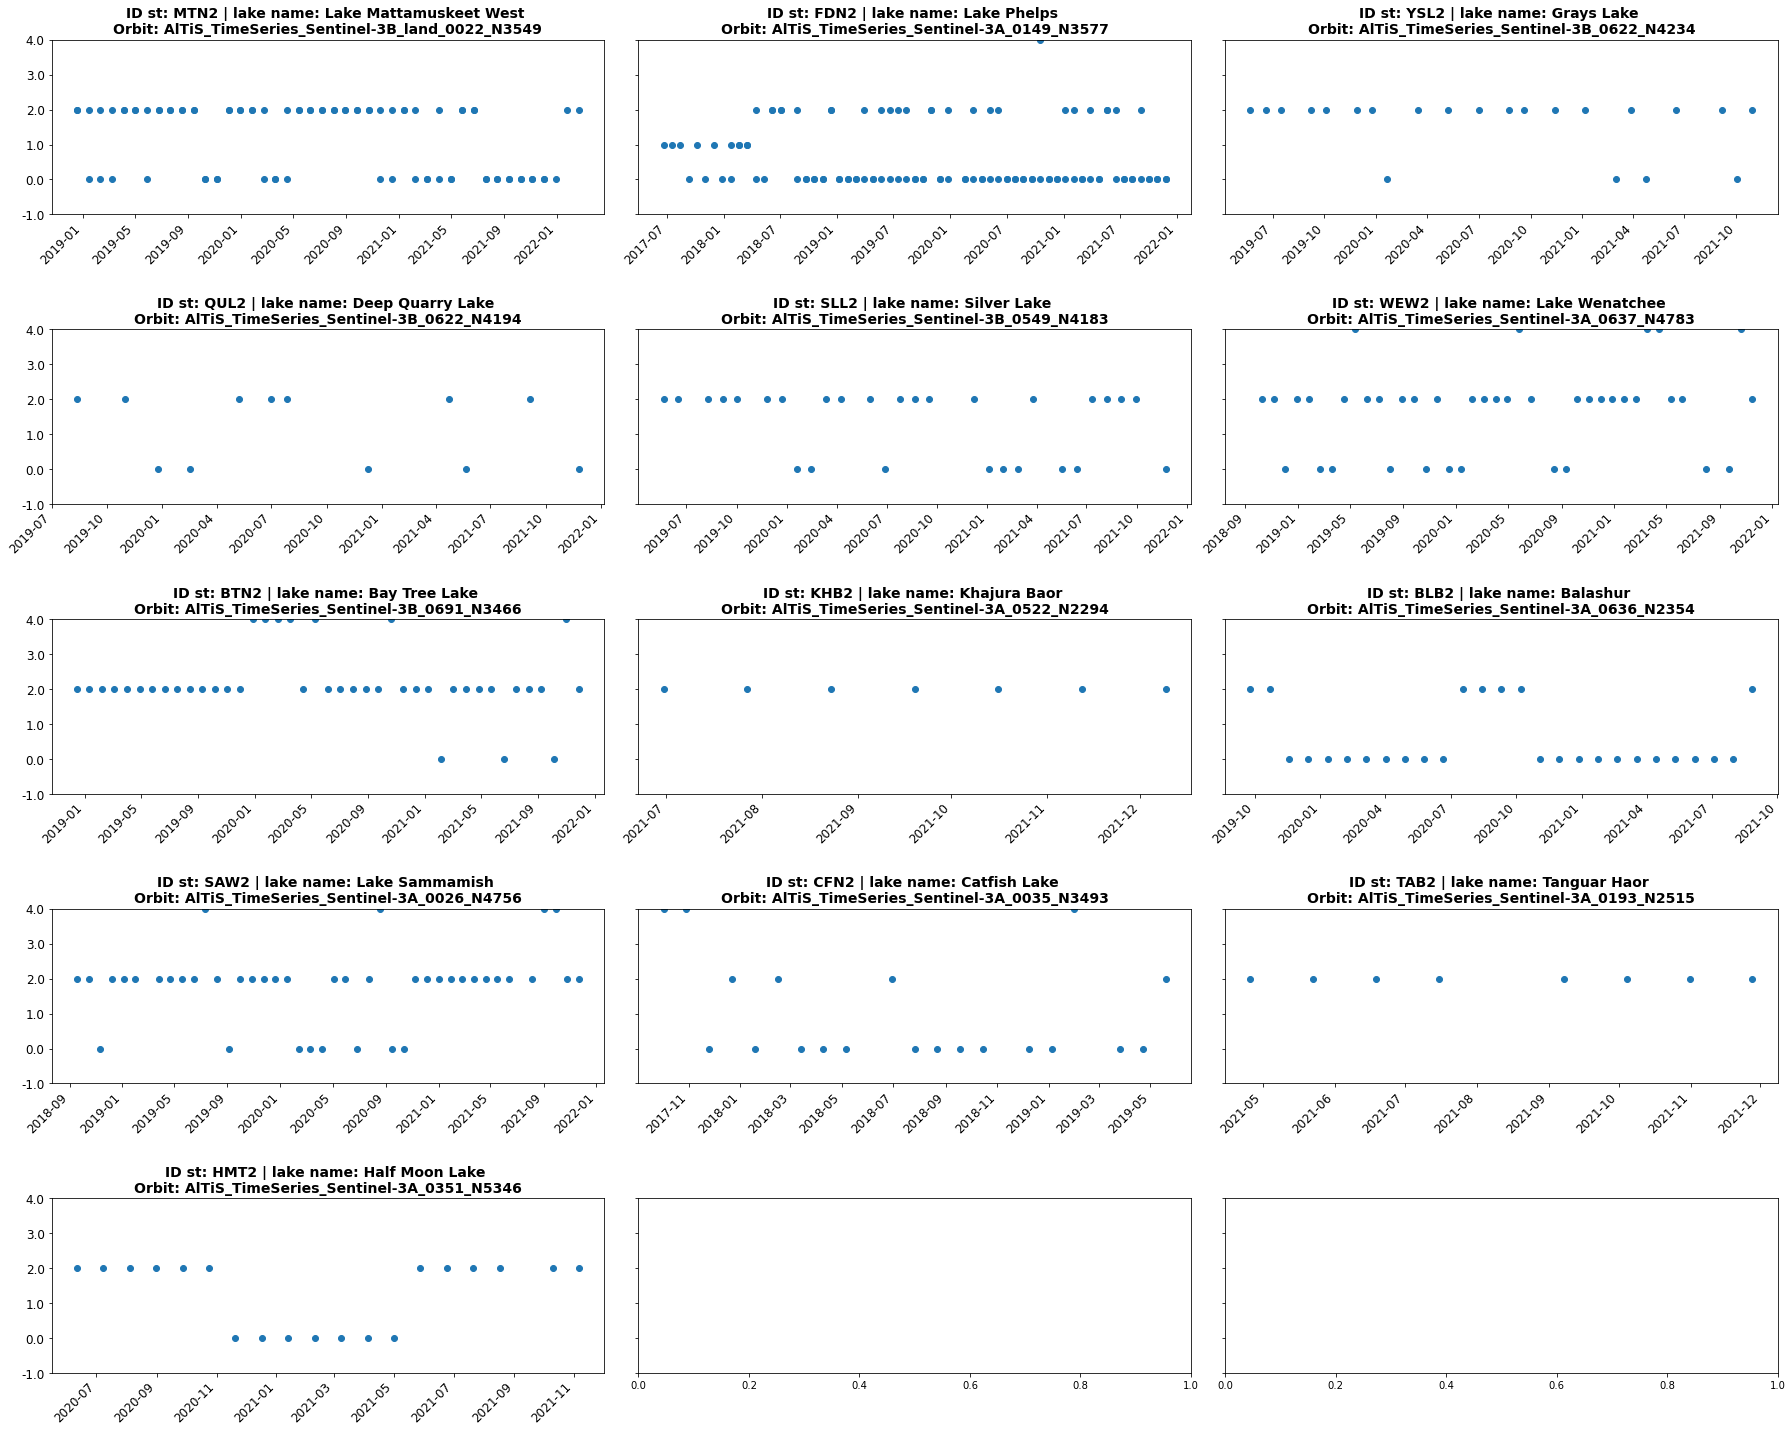

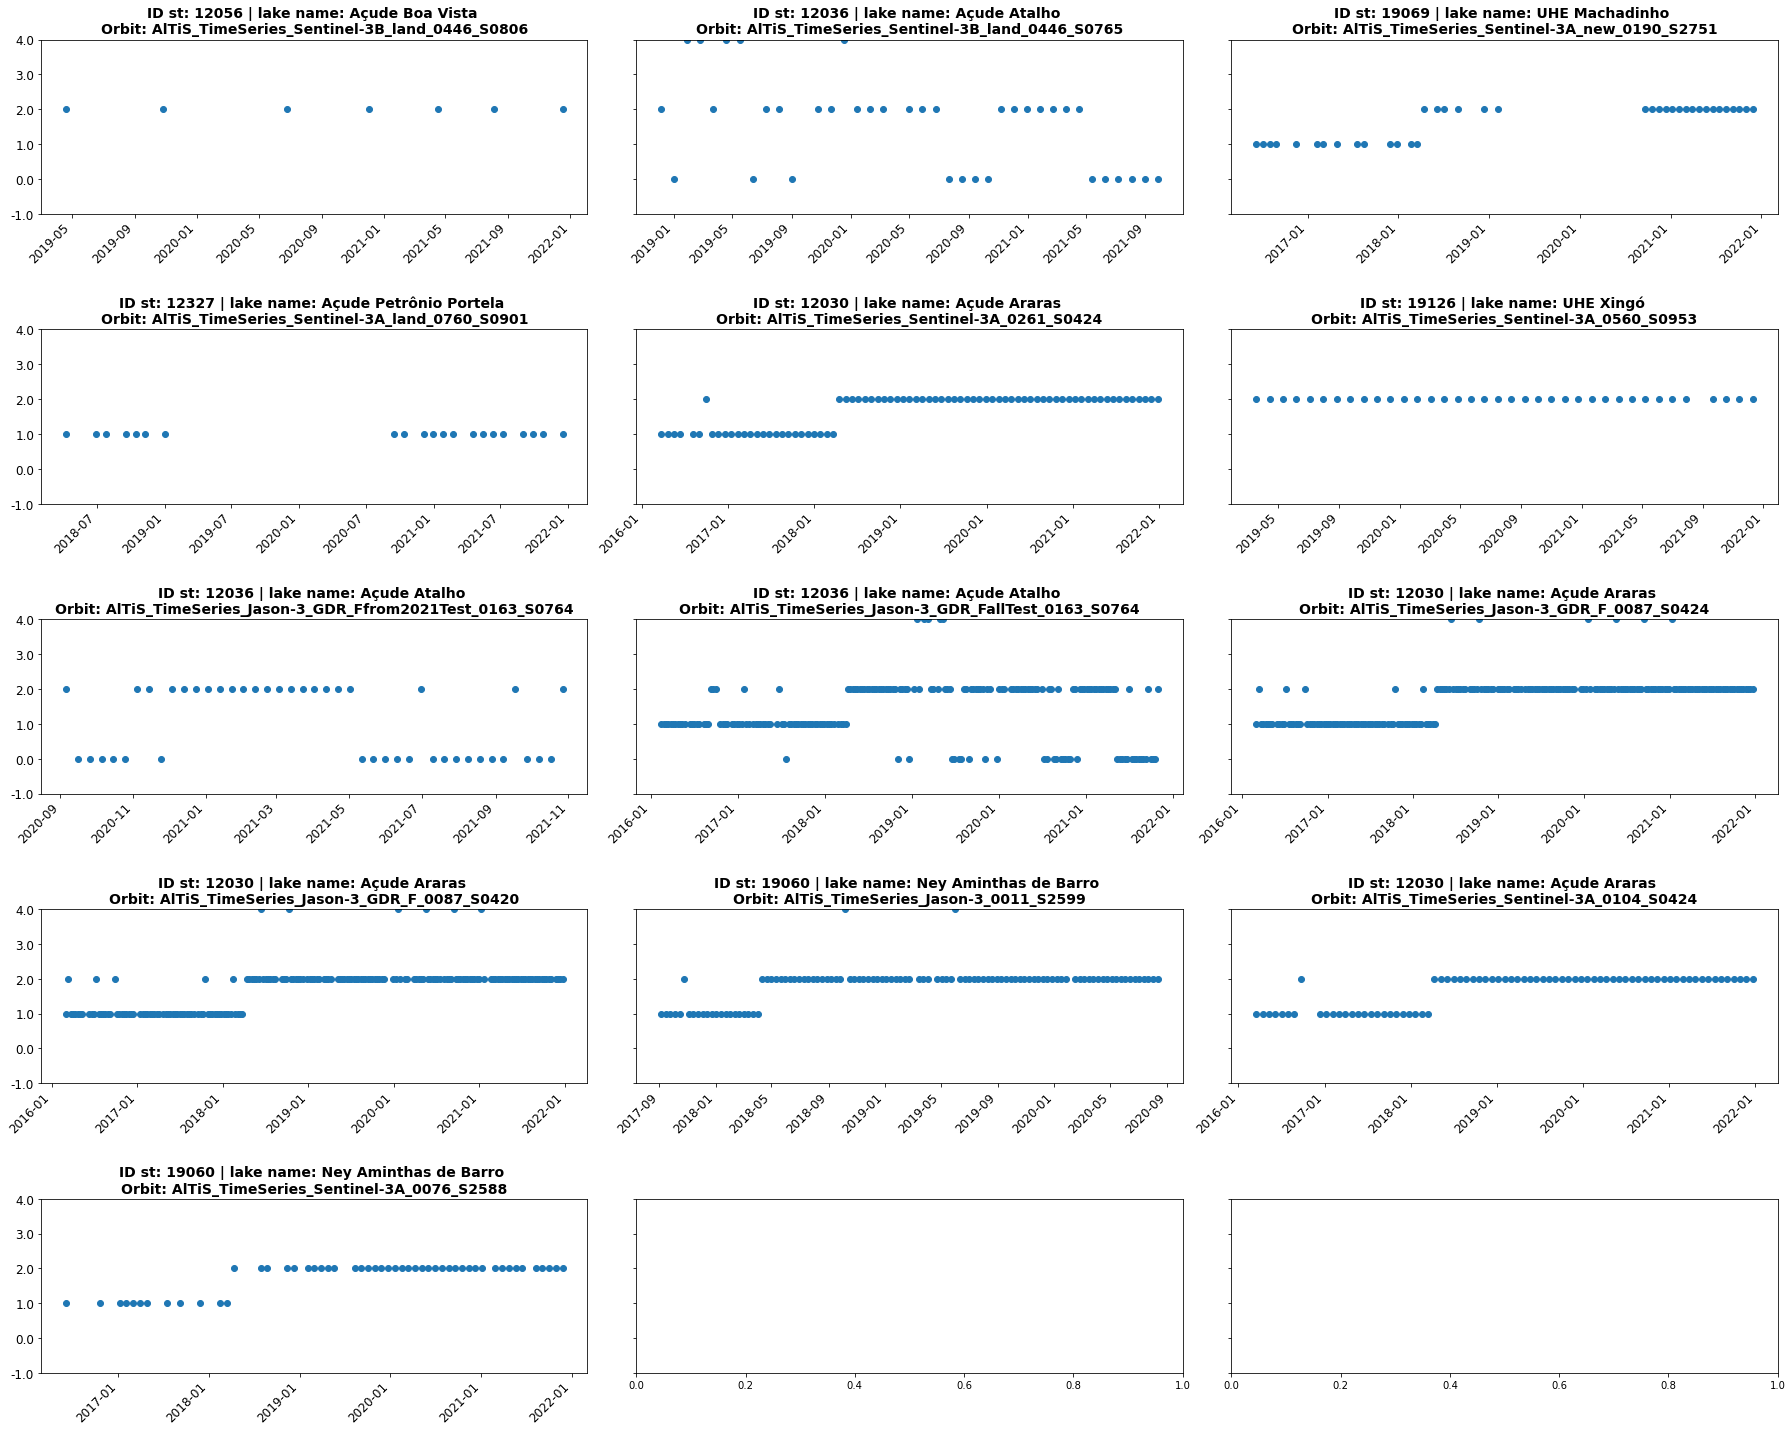

In [48]:
# om='AlTiS_TimeSeries_Sentinel-3A_0562_S4128'
# df_final_altis.columns

# df=df_final_altis.copy()

# other_sources=['ARHN', 'USGS']
# df.loc[df['source'].isin(other_sources),'group']=1
# df.loc[df['source']=='LOCSS','group']=2
# df.loc[df['source']=='RVBR','group']=3


# row_f=5
# col_f=3
# w=25
# h=20
# for s in df['group'].unique():
#     df_g=df.loc[df['group']==s].copy()
    
#     fig, axs=plt.subplots(row_f,col_f, figsize=(w,h), sharey=True)
#     ymin=-1
#     ymax=4
    
#     i=0
#     j=0
#     for om in df_g['name_altis'].unique():
#         df_val=df_g.loc[df_g['name_altis']==om]
#         labelg='ID st: '+df_val['gauge_id'].iloc[0]+' | '+'lake name: '+df_val['lake_name'].iloc[0]+\
#             ' \nOrbit: '+om#'ID st: '+df_val['ground_st_1'].iloc[0]+' \nOrbit: '+om
#     # df_metrics=df_cm.loc[df_cm['altis']==om]
#     # ic(df_metrics)
#     # error_m_text='lake = '+df_metrics['lake_name'].iloc[0]+'\n($R$ = '+str(np.round(df_metrics['R'].iloc[0], decimals=2))+' | '+\
#     #    '$\\rho$ = '+str(np.round(df_metrics['RHO'].iloc[0],decimals=2))+' | n = '+str(df_metrics['n_obs'].iloc[0])+')'#+\
#     # df_final_ground.columns
#     # fig, ax = plt.subplots()
#     # plt.subplot(row_f,col_f,nfig)
#     #Observed Vs Estimates
#         axs[i][j].scatter(df_val['date'],df_val['n_cd_d_5'])#, linestyle=None, marker='o')
#         plt.ylim(ymin,ymax)
    
#         plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal places    
#         axs[i][j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#         for label in axs[i][j].get_xticklabels(which='major'):
#             label.set(rotation=45, horizontalalignment='right', fontsize=12)
#         for ylabel in axs[i][j].get_yticklabels(which='major'):
#             ylabel.set(fontsize=12)
#         fig.tight_layout(h_pad=3, w_pad=1)
    
#         axs[i][j].set_title(labelg, fontdict={'fontsize':14,  'fontweight':'bold'})
#     # axs[i][j].text(0.7,0.2,error_m_text, fontsize=14,weight='bold',
#     #                horizontalalignment='center', verticalalignment='center', transform=axs[i][j].transAxes)
#         if j>=col_f-1:
#             j=0
#             if i<=row_f-1:
#                 i=i+1
#         else:
#             j=j+1
        
#     plt.show()
# # axs.legend()


In [12]:
df_final_altis.columns

Index(['Unnamed: 0', 'decimal_y', 'height', 'year', 'month', 'day', 'hour',
       'date', 'name_altis', 'gauge_id', 'median_d_5', 'mad_d_5', 'mean_d_5',
       'std_d_5', 'count_d_5', 'val_cd_d_5', 'type_cd_d_5', 'ndays_cd_d_5',
       'mea_cd_d_5', 'mad_cd_d_5', 'std_cd_d_5', 'n_cd_d_5', 'lake_name',
       'source'],
      dtype='object')

In [112]:
# om='AlTiS_TimeSeries_Sentinel-3A_0562_S4128'
# df_final_altis.columns


# i=0
# j=0
# row_f=9
# col_f=4
# w=30
# h=30
# this_source='ALL'


# x_boxp=df_final_altis['name_altis'].unique()
# df=df_final_altis[['n_cd_d_5','name_altis','decimal_y', 'ground_st_1']].copy()
# df['name_altis_1']=[x[1] for x in df['name_altis'].str.split('-')]
# df['name_altis_1']=df['name_altis_1']+'_'+df['ground_st_1']
# df
# df_bp=df.pivot(index=['decimal_y','ground_st_1'],columns='name_altis', values='n_cd_d_5').reset_index().reset_index()


# # ic(df_bp)


In [50]:
# #NO need anymore
# import matplotlib.pyplot as plt
# import numpy as np
# from datetime import date


# plt.rcParams["figure.figsize"] = (20,3)
# # stations=df_stats_duplicates_neq['gauge_id'].unique()
# # for st in stations:
# #     df=df_stats_duplicates_neq.loc[df_stats_duplicates_neq['gauge_id']==st]
# # df_stats_duplicates_neq['region']=[x[2:] for x in df_stats_duplicates_neq[st_id_fd]]
# df_stats_duplicates_neq_1=df_stats_duplicates_neq.loc[df_stats_duplicates_neq['region']!='R2']
# x=      df_stats_duplicates_neq_1[st_id_fd].values
# mins =  df_stats_duplicates_neq_1['height_min'].values
# maxes = df_stats_duplicates_neq_1['height_max'].values
# means = df_stats_duplicates_neq_1['height_mean'].values
# std =   df_stats_duplicates_neq_1['height_std'].values

# # create stacked errorbars:
# plt.errorbar(x=x, y=means, yerr=std, fmt='.k',ecolor='gray', lw=2)
# plt.errorbar(x, means, [means - mins, maxes - means],
#          fmt='.b', ecolor='blue', lw=1)
# plt.xticks(rotation=90)
# plt.ylabel("Average Difference\nWSE same date (m)")
# plt.xlabel("Gauge ID")
# plt.ylim(0, 12)
# plt.savefig('../data/avg_diff_WSE_same_date'+date.today().strftime('%Y%m%d')+'.png')

NameError: name 'df_stats_duplicates_neq' is not defined

In [7]:
#If everything will restart put 0, otherwise put a different number. This restars the dataframes with the output
start=0
#save plots?
save_plot=True
#Plot?
show_plot=True
#save results
save_res=True

In [8]:
txt_g=widgets.Text(
    value='LOCSS',
    placeholder='Add the group',
    description='Group data:',
    disabled=False
)
btn_g=widgets.Button(
    description='Define'
)
display(txt_g, btn_g)

def on_button_clicked(b):
    print("Value group ",txt_g.value)
    group=txt_g.value

btn_g.on_click(on_button_clicked)

Text(value='LOCSS', description='Group data:', placeholder='Add the group')

Button(description='Define', style=ButtonStyle())

In [9]:
#Pending programming event
group=txt_g.value 
group

''

In [10]:
# dic_groups={'LOCSS':locss_g,'OFNAT':off_nat_g,'RVBR':res_g}
# group='LOCSS'

if group =='':
    df=df_final_altis.copy()
    df['gauge_altis']=df.gauge_id +'_'+df.name_altis
    row_f=8
    col_f=5
    w=30
    h=20
    # df.loc[df['gauge_id']=='FDN2', 'lake_name']='Lake Phelps'
    # df.loc[df['gauge_id']=='PHN2', 'lake_name']='Lake Phelps East'
    # df.loc[df['gauge_id']=='VCN2', 'lake_name']='Lake Mattamuskeet East'
elif group=='OFNAT':
    df=df_final_altis.loc[df_final_altis['gauge_id'].isin(dic_groups[group])].copy()
    df['gauge_altis']=df.gauge_id +'_'+df.name_altis
    row_f=4
    col_f=3
    w=30
    h=20    
elif group=='LOCSS':
    df=df_final_altis.loc[df_final_altis['gauge_id'].isin(dic_groups[group])].copy()
    df['gauge_altis']=df.gauge_id +'_'+df.name_altis
    row_f=5
    col_f=3
    w=30
    h=20
    # df.loc[df['gauge_id']=='FDN2', 'lake_name']='Lake Phelps'
    # df.loc[df['gauge_id']=='PHN2', 'lake_name']='Lake Phelps East'
    # df.loc[df['gauge_id']=='VCN2', 'lake_name']='Lake Mattamuskeet East'
    ##Filter
    # filter_out=['MTN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549','FDN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577']
    # df=df.loc[~df['gauge_altis'].isin(filter_out)].copy()
elif group=='RVBR':
    df=df_final_altis.loc[df_final_altis['gauge_id'].isin(dic_groups[group])].copy()
    df['gauge_altis']=df.gauge_id +'_'+df.name_altis
    row_f=5
    col_f=3
    w=30
    h=20
    
# group='OFNAT'
# df=df_final_altis.loc[df_final_altis['gauge_id'].isin(dic_groups[group])].copy()
# row_f=3
# col_f=4
# w=30
# h=20

# group='RVBR'
# df=df_final_altis.loc[df_final_altis['gauge_id'].isin(dic_groups[group])].copy()
# row_f=3
# col_f=4
# w=30
# h=20

In [175]:
row_f

5

In [11]:

df_ground_cp=df_final_ground.copy()
df_ground_cp['gauge_altis']=df_ground_cp.gauge_id +'_'+df_ground_cp.name_altis

In [12]:
df_validation=df.copy()
df_validation.gauge_id.unique()

#filter for Grant
#df_validation=df_validation.loc[~df_validation['gauge_id'].isin(['FDN2', 'MTN2'])]


array(['2028', '1824', '2234', '2316', 'MTN2', 'FDN2', 'YSL2', 'QUL2',
       'SLL2', 'WEW2', 'BTN2', 'KHB2', 'BLB2', 'SAW2', 'CFN2', 'VCN2',
       'TAB2', 'PHN2', 'HMT2', '12056', '12036', '19069', '12327',
       '12030', '19126', '19060', '2464800', '6903880', '6604000'],
      dtype=object)

new me 13.868951567169137
1 12030_AlTiS_TimeSeries_Sentinel-3A_0261_S0424
new me 15.306191468106972
2 12030_AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0424
new me 15.075955031550697
3 12030_AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420
new me 14.261842349138607
4 12030_AlTiS_TimeSeries_Sentinel-3A_0104_S0424
new me 10.099609950363805
5 12036_AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_0163_S0764
new me -89.45041919950846
6 12036_AlTiS_TimeSeries_Jason-3_GDR_FallTest_0163_S0764
new me 9.814094542022952
7 12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765
new me -332.18513571428326
8 12056_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0806
new me 5.769086672316386
9 12327_AlTiS_TimeSeries_Sentinel-3A_land_0760_S0901
new me 51.545612686567274
10 BLB2_AlTiS_TimeSeries_Sentinel-3A_0636_N2354
new me 13.681631654883551
11 BTN2_AlTiS_TimeSeries_Sentinel-3B_0691_N3466
new me -394.13023662807177
12 6604000_AlTiS_TimeSeries_Sentinel-3B_0480_N4348
new me 27.667005350664816
13 CFN2_AlTiS_TimeSeries_Sentinel-3A_0035

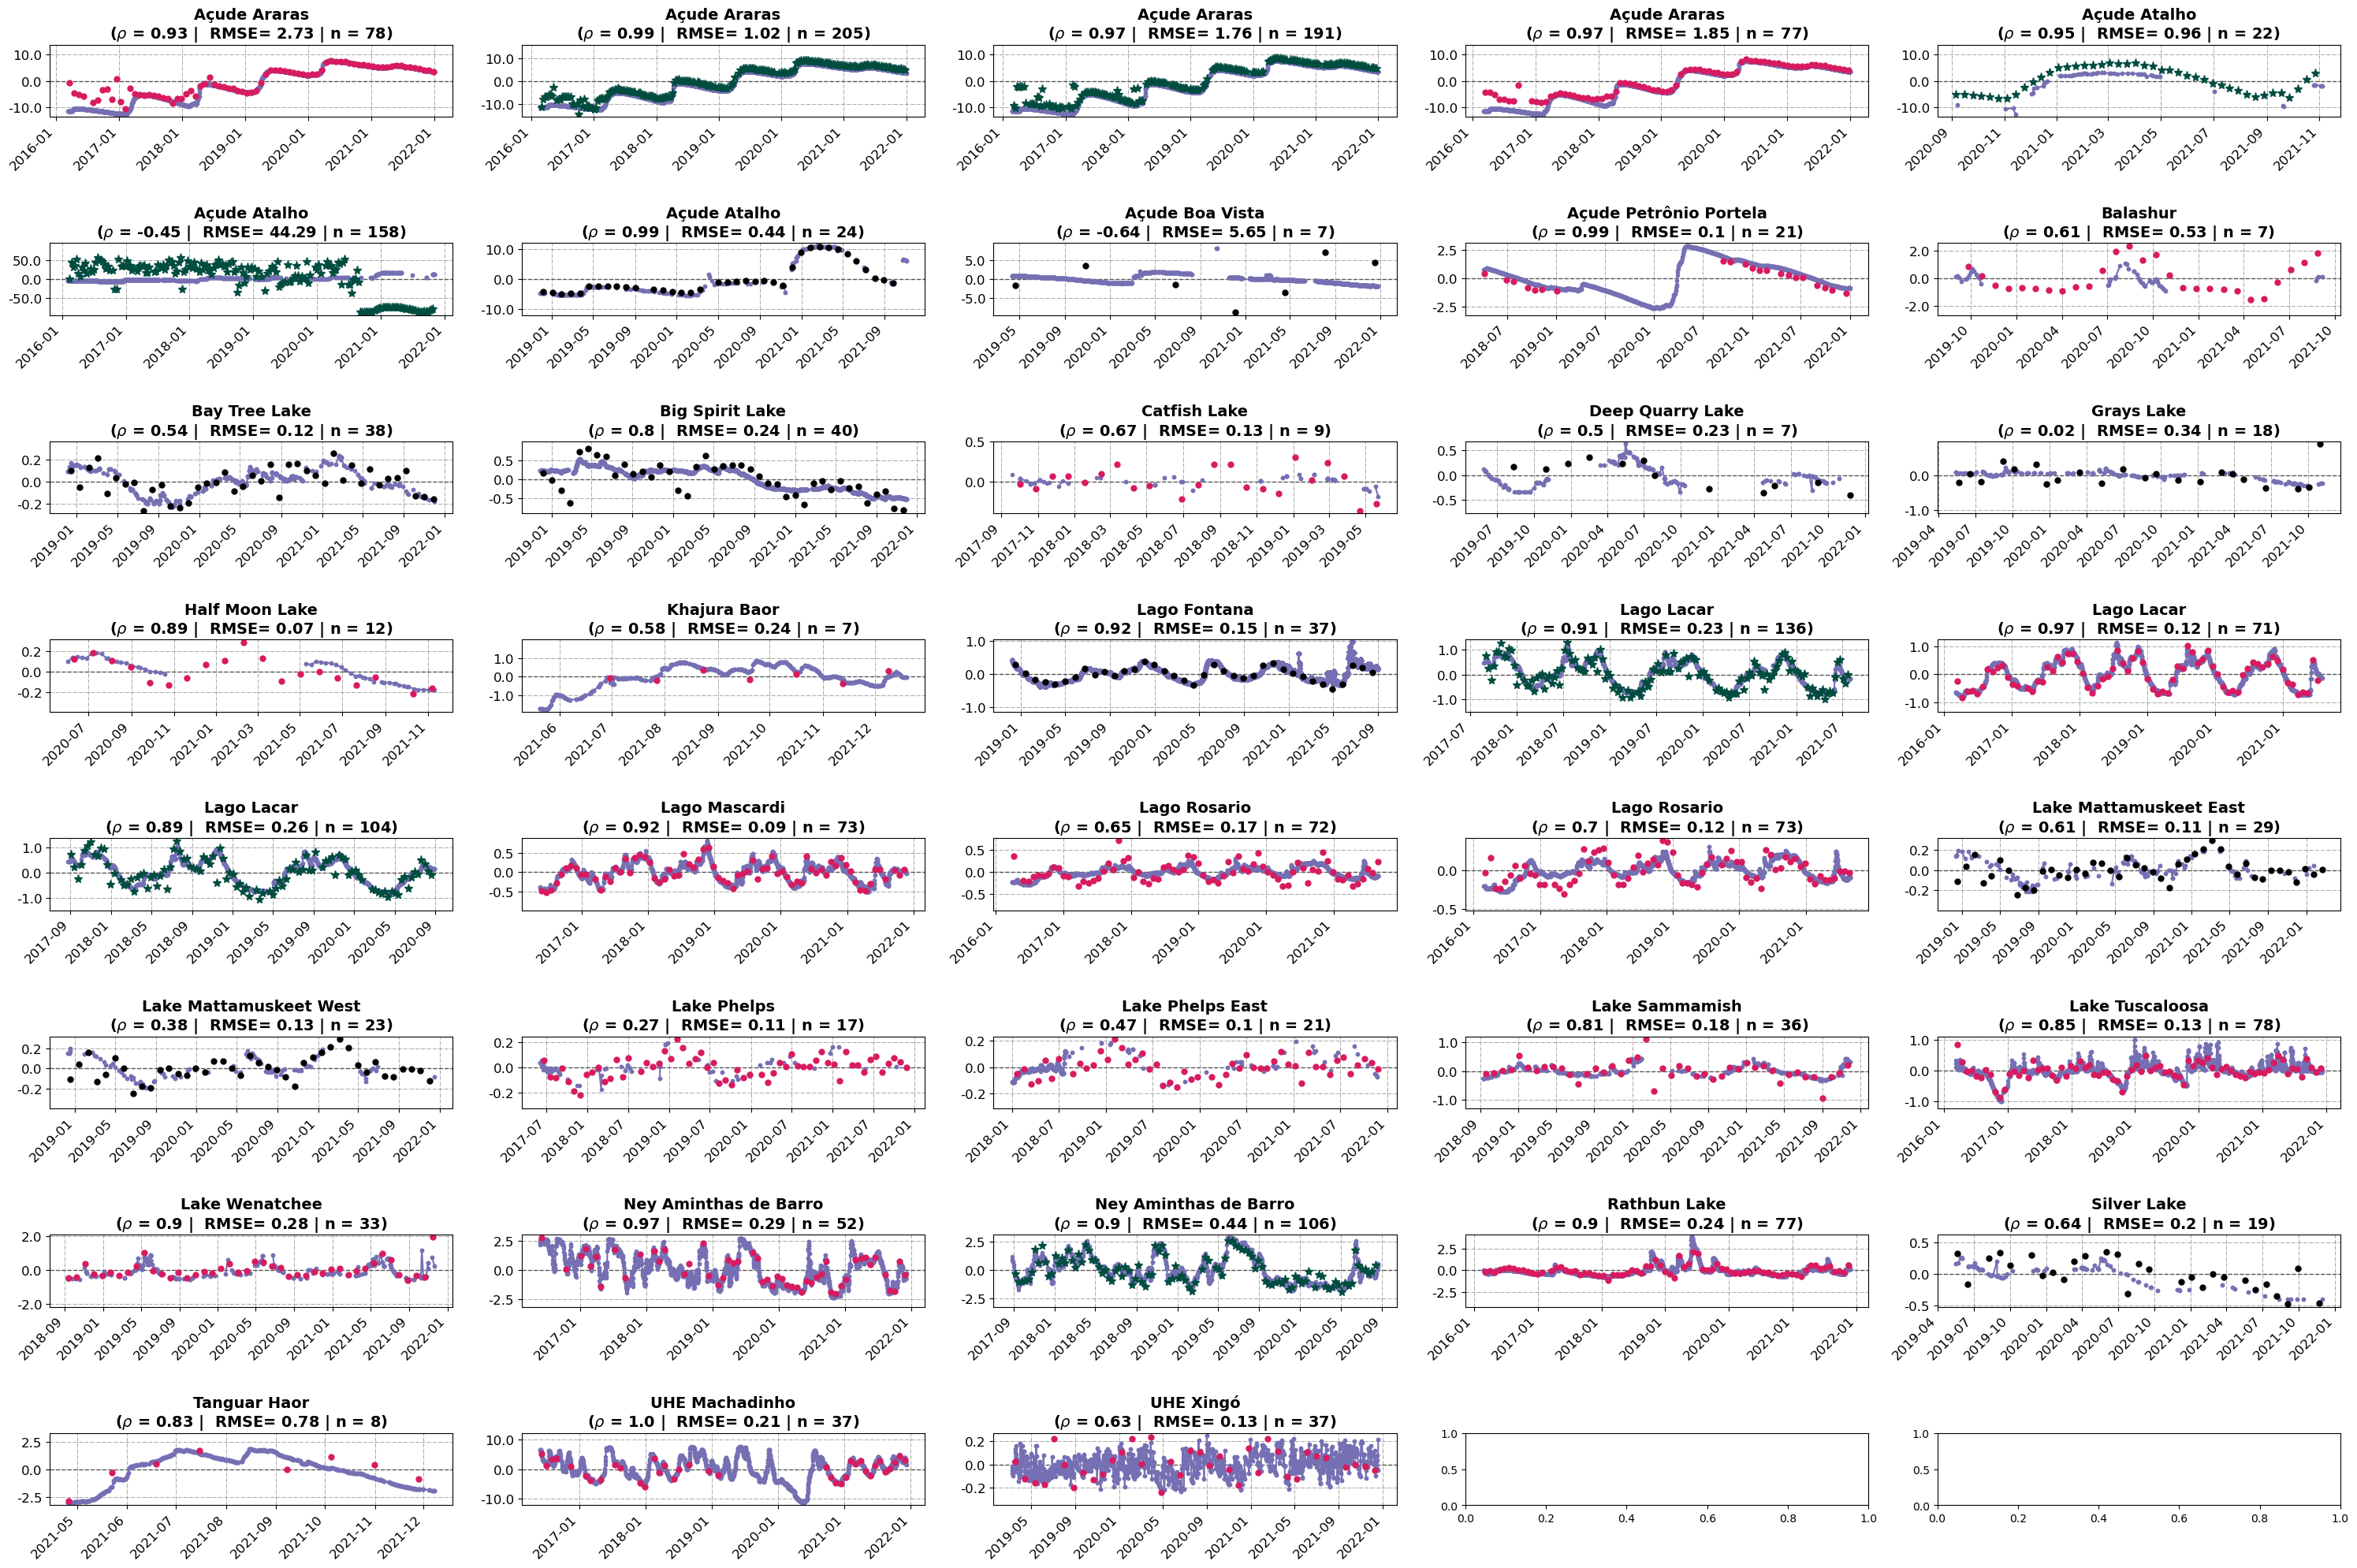

Data save to:
 ../data/results/comparison__20230118_17_30.csv


'Deep quarry freeze Sylver probably freez Half Moon too. Grays does freeze '

In [17]:
#Test to determine potential number of figures
#path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'


# if platform.system()=='Linux':
#     altis_csv=pd.read_csv(path, sep=',',encoding='iso-8859-1')
# else:
#     altis_csv=pd.read_csv(path, sep=',', encoding='windows-1252')  



time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
path_name='../data/results/plots_mv_cd_'+group+'_'+time_fig+'/'

if start==0:
    df_cm=pd.DataFrame()
    

# path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'


st_fd='gauge_id'
# st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
# altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
# nodataalti=-9999

# wse_ref='e'
j=1

# if group not in ['ALL', 'ICECV', '']:
#     df_final_validation=df_validation.loc[df_validation['source']==group].copy()
#     # group='ALL'
# else:
df_final_validation=df_validation.copy()
    # group='ALL'

data_source=group

# altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
# #filter only altis time series with ground observations
# altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]

fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
axs=axs.ravel()
x_ax=0
y_ax=0
c=0
df_final_validation=df_final_validation.sort_values(by='lake_name')


val_fd='val_cd_d_5' #Closest

# val_fd='median_d_5' #median between the values
altis_data_fd='height'
lake_name_fd='lake_name'
g_gauge_id_fd='gauge_id'
altis_name_fd='gauge_altis'
source_fd='source'


for altis in df_final_validation[altis_name_fd].unique():
    

    #Sel altis
    df_altis_c=df_final_validation.loc[df_final_validation[altis_name_fd]==altis].copy()
    #Get lake name and station
    lake_name=df_altis_c[lake_name_fd].iloc[0]
    gauge_id=df_altis_c[st_fd].iloc[0]
    go_source=df_altis_c[source_fd].iloc[0]
    df_ground_c=df_ground_cp.loc[df_ground_cp[altis_name_fd]==altis]
    name_altis=df_ground_c.name_altis.iloc[0]
    altis_name=altis
    # get metrics 
    metrics=get_comp_metrics(ts_obs=df_altis_c[val_fd].to_numpy(),ts_est=df_altis_c[altis_data_fd].to_numpy())
        
    #Add coef variation of the observations
        
    cv=np.nanstd(df_altis_c[val_fd].to_numpy())/np.nanmean(df_altis_c[val_fd].to_numpy())*100
    std_obs=np.nanstd(df_altis_c[val_fd].to_numpy())
    mean_obs=np.nanmean(df_altis_c[val_fd].to_numpy())
        
    # Add to the output dataframe the range of dates of analysis in UTC
    altis_min_utc_date=df_altis_c[altis_date_fd].dt.normalize().min()
    altis_max_utc_date=df_altis_c[altis_date_fd].dt.normalize().max()
    ground_min_utc_date=df_ground_c[altis_date_fd].dt.normalize().min()
    ground_max_utc_date=df_ground_c[altis_date_fd].dt.normalize().max()
    #ic(altis_min_utc_date,altis_max_utc_date,ground_min_utc_date,ground_max_utc_date)
    
    #Flashiness index 
    
    sum_swe=df_altis_c[val_fd].sum()
    diff_swe=np.abs(df_altis_c[val_fd].diff()).sum()
    rb_index=diff_swe/sum_swe
    
    # Standard deviation of the differences. Coefficient of variation of the differences
    #https://stats.stackexchange.com/questions/24607/how-to-measure-smoothness-of-a-time-series-in-r
    #I'll save the std of the diffences and the mean of the differences separated
    #sd(diff(x))/abs(mean(diff(x)))
    std_diff=np.nanstd(df_altis_c[val_fd].diff().to_numpy())
    mean_diff=np.nanmean(df_altis_c[val_fd].diff().to_numpy())
    

    #Create a output dataframe with the metrics
    cm_dict={'result_id':j,'station':[gauge_id],'lake_name':lake_name, 'altis':[altis_name],'name_altis':name_altis, 'source':[go_source], 'method':['Moving Window'],
            'R':metrics['PR'],'PR_pvalue':metrics['PR_p_val'],'RHO':metrics['RHO'],'RHO_pvalue':metrics['RHO_p_val'],'NSF':metrics['NSF'],'RMSE':metrics['RMSE_ts2'],'APL':metrics['ampl_ts1'],
            'ME':metrics['me'],'VE':metrics['ve'], 'number_obs':metrics['size_obs'],'number_altis':metrics['size_est'],'cv_obs':cv,
            'rb_index':rb_index,'std_diff':std_diff,'std_obs':std_obs, 'mean_obs':mean_obs,
            'mean_diff':mean_diff, 'sat_min_utcdate':altis_min_utc_date,'sat_max_utcdate':altis_max_utc_date,'grd_min_utcdate':ground_min_utc_date,'grd_max_utcdate':ground_max_utc_date}


    df_cmi=pd.DataFrame(cm_dict)

    df_cm=pd.concat((df_cm,df_cmi), axis=0)
    #df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
    #df_ground_cp=pd.concat((df_ground_cp,df_ground_c), axis=0)
    # print('error', me_alti_insi)
    #Superscript https://stackoverflow.com/questions/21226868/superscript-in-python-plots
    error_m_text='\n($\\rho$ = '+str(np.round(cm_dict['RHO'], decimals=2))+' | '+\
    ' RMSE= '+str(np.round(cm_dict['RMSE'],decimals=2))+' | n = '+str(cm_dict['number_obs'])+')'#+\
    # 'VE: '+str(np.round(ve_alti_insi, decimals=4))

    labels=altis_name.split('_')[2]
    # labelg=' '+gauge_id
    labelg=lake_name
    labeli='Interp ground to altis'



    dfg=df_ground_c
    dfs=df_altis_c

    # dic_intp={'decimal_y':df_altis_plot['decimal_y'].to_numpy(), 'height':inh_2_altidy}


    date_plot_fd='date'#'decimal_y'
    height_plot_fd='height'
    nfig=j
    if show_plot:
        #Add ice covered
        fill_between=None #{'fill':'SLIDE_snowIce',
                          #'lim':0.5}
        plt.subplot(row_f,col_f,nfig)
#             https://stackoverflow.com/questions/62443158/plots-not-working-in-for-loop-i-am-getting-only-the-last-element-plot
        plt=plot_dev_mean_publish(fig,nfig,dfs, dfg, go_source, gauge_id, altis_name, date_plot_fd, height_plot_fd, labels, labelg, fill_between, error_m_text)
        print(j, altis)
    
    j=j+1
if save_plot:     
    plt.savefig('../data/results/'+data_source+'_'+time_fig+'_closest_icgt0.png')#, dpi=300, format='png')    
    print('Figure save to:\n','../data/results/'+data_source+'_'+time_fig+'_closest_icgt0.png')
if show_plot:
    plt.show() 

df_final_validation['method']='Moving Window'
# df_ground_cp['method']='Moving Window'


#Save results
if save_res:
    # ic(df_cm.head())
    #Save comparison metrics 
    df_cm['R']=[np.round(v, decimals=3) for v in df_cm['R']]
    df_cm['RHO']=[np.round(v, decimals=3) for v in df_cm['RHO']]
    df_cm['NSF']=[np.round(v, decimals=3) for v in df_cm['NSF']]
    df_cm['RMSE']=[np.round(v, decimals=3) for v in df_cm['RMSE']]
    df_cm['APL']=[np.round(v, decimals=3) for v in df_cm['APL']]
    #df_cm['ME']=[np.round(v, decimals=3) for v in df_cm['ME']]
    df_cm['VE']=[np.round(v, decimals=3) for v in df_cm['VE']]
    df_cm['n_obs']=[np.round(v, decimals=3) for v in df_cm['number_obs']]
    df_cm['cv_obs']=[np.round(v, decimals=3) for v in df_cm['cv_obs']]

    
    cols=['result_id','station','lake_name', 'altis', 'name_altis','source', 'method','R','PR_pvalue','RHO','RHO_pvalue','NSF','RMSE', 'APL', 'ME','VE','cv_obs','std_obs','mean_obs', 'n_obs','rb_index','std_diff','mean_diff','sat_min_utcdate','sat_max_utcdate', 'grd_min_utcdate','grd_max_utcdate']     
    df_cm[cols].to_csv('../data/results/comparison_'+group+'_'+time_fig+'.csv', sep=',')
    print('Data save to:\n','../data/results/comparison_'+group+'_'+time_fig+'.csv')

'''Deep quarry freeze Sylver probably freez Half Moon too. Grays does freeze '''

In [53]:
df_cm.shape

(38, 20)

In [22]:
# om='AlTiS_TimeSeries_Sentinel-3A_0562_S4128'
# # df_final_altis.columns


i=0
j=0
# row_f=9
# col_f=4
# w=30
# h=30

fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
for om in df_final_validation[altis_name_fd].unique():
    df_val=df_final_validation.loc[df_final_validation[altis_name_fd]==om]
    df_val
    df_metrics=df_cm.loc[df_cm['altis']==om]
    # ic(df_metrics)
    error_m_text='lake = '+df_metrics['lake_name'].iloc[0]+'\n($R$ = '+str(np.round(df_metrics['R'].iloc[0], decimals=2))+' | '+\
       '$\\rho$ = '+str(np.round(df_metrics['RHO'].iloc[0],decimals=2))+' | n = '+str(df_metrics['number_obs'].iloc[0])+')'#+\
    # df_final_ground.columns
    # fig, ax = plt.subplots()
    # plt.subplot(row_f,col_f,nfig)
    #Observed Vs Estimates
    axs[i][j].scatter(df_val[altis_data_fd]-np.mean(df_val[altis_data_fd]),df_val[val_fd]-np.mean(df_val[val_fd]))#, linestyle=None, marker='o')
    fig.tight_layout(h_pad=3, w_pad=2)
    axs[i][j].text(0.7,0.2,error_m_text, fontsize=14,weight='bold',
                   horizontalalignment='center', verticalalignment='center', transform=axs[i][j].transAxes)
    if j>=col_f-1:
        j=0
        if i<=row_f-1:
            i=i+1
    else:
        j=j+1
plt.savefig('../data/results/'+data_source+'_'+time_fig+'_closest_xy_icgt0.png')#, dpi=300, format='svg')    
print('Figure save to:\n','../data/results/'+data_source+'_'+time_fig+'_closest_xy_icgt0.png')    

<IPython.core.display.Javascript object>

Figure save to:
 ../data/results/_20221210_12_43_closest_xy_icgt0.png


In [25]:
df_melt=pd.melt(df_cm, id_vars=['lake_name','station'], 
             value_vars=['RHO', 'R','PR_pvalue','RHO_pvalue'], ignore_index=True)
df_melt

,lake_name,station,variable,value
0,Açude Araras,12030,RHO,9.280000e-01
1,Açude Araras,12030,RHO,9.930000e-01
2,Açude Araras,12030,RHO,9.670000e-01
3,Açude Araras,12030,RHO,9.750000e-01
4,Açude Atalho,12036,RHO,9.550000e-01
...,...,...,...,...
147,Rathbun Lake,6903880,RHO_pvalue,2.097716e-28
148,Silver Lake,SLL2,RHO_pvalue,3.073354e-03
149,Tanguar Haor,TAB2,RHO_pvalue,1.017554e-02
150,UHE Machadinho,19069,RHO_pvalue,6.797805e-41


In [60]:
df_cm.ME

0   -0.0
0    0.0
0   -0.0
0   -0.0
0    0.0
0   -0.0
0   -0.0
0    0.0
0   -0.0
0   -0.0
0    0.0
0    0.0
0    0.0
Name: ME, dtype: float64

['$\\rho$', 'R']


[Text(0, 0, '$\\rho$'), Text(1, 0, 'R')]

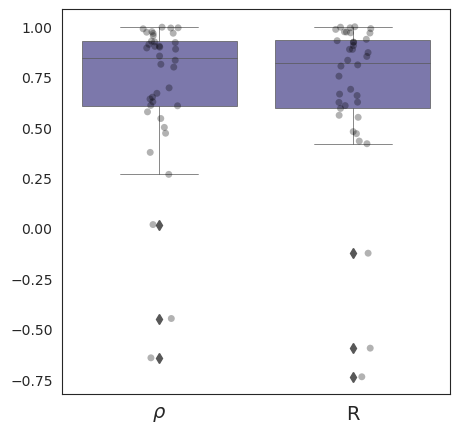

In [40]:
#Compare R and RHO

sns.set_style('white')
plt.rcParams["figure.figsize"] = (5,5)
# plt.rcParams['font.family']='Arial'


# print(df.head())

df=df_melt.loc[df_melt['variable'].isin(['R', 'RHO'])].copy()


x_fd='variable'
y_fd='value'
hue='variable'
pal=sns.color_palette(["#7570b3", "#7570b3"], as_cmap=False)
#facet_kws={'sharey': False, 'sharex': True}
#row='variable'#'source'
    # for i in ['r2', 'RMSE']:
    # df=df.loc[df[col]==i]


# g = sns.relplot(data=df,facet_kws=facet_kws,
#             x=x_fd, y=y_fd,#palette=pal,
#             hue=hue,# col=col,size=size,
#             row=row,# col_wrap=2,
#             kind="scatter", height=4, aspect=10/4)#,
                #join=False)#,
            #dodge=True)
    #                height=4, aspect=.7)
# Iterating through axes and names
# names=['$\\rho$', 'RMSE (m)']
i=0
xlabels=['$\\rho$', 'R']
print(xlabels)
# for name, ax in zip(['R','RHO'], axes.flatten()):
    # sns.boxplot(y=name, x= "a", data=df, orient='v', ax=ax)
    # d_to_plot=df.loc[df[row]==name]
g = sns.boxplot(data=df,#facet_kws=facet_kws,
            y=y_fd,palette=pal,
            x=hue,
            #ax=ax, 
            linewidth=.5)
sns.stripplot(x=hue, y=y_fd, data=df, marker="o", alpha=0.3, color="black")
g.set_xlabel("", fontsize=16)
g.set_ylabel('', fontsize=16)
# g.set_yticklabels(ax.get_yticks(), size = 14)
g.set_xticklabels(xlabels, size = 14)
    # i=i+1
    #,# col=col,size=size,
            #row=row,# col_wrap=2,
            #height=4, aspect=10/4)#,
# sns.set(font_scale = 1)
# sns.move_legend(
#         g, "center right",
#         bbox_to_anchor=(1.1, .5),
#         ncol=1,
#         title=None, frameon=True,
#     )
#     #Change legend text (https://stackoverflow.com/questions/53116532/modify-seaborn-line-relplot-legend-title)
# g._legend.texts[0].set_text('LOCSS')
# # g._legend.texts[leg2_pos].set_text('Mean lake area \n(Km$^2$)')
# # g.set_title('Ratio area covered \nby orbit')
# g.set_xticklabels(rotation=90)
# g.set_xlabel(xlabel='Group of gauges', size=15)




In [314]:
df_cm_closest.head()#=df_cm.copy()


,station,lake_name,altis,source,method,R,PR_pvalue,RHO,RHO_pvalue,NSF,RMSE,APL,ME,VE,number_obs,number_altis,cv_obs,sat_min_utcdate,sat_max_utcdate
0,2464800,Lago Mascardi,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,USGS,Moving Window,0.936523,4.838296e-34,0.924263,2.064745e-31,0.876757,0.093222,1.148208,-8.251543e-14,0.008690,73,73,18.895559,2016-05-25 00:00:00+00:00,2021-11-13 00:00:00+00:00
0,2464800,Lago Rosario,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,USGS,Moving Window,0.657618,2.607051e-10,0.696245,7.986033e-12,0.428105,0.123315,0.685521,-6.092539e-15,0.015206,73,73,15.292348,2016-03-08 00:00:00+00:00,2021-08-27 00:00:00+00:00
0,2464800,Lago Lacar,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,USGS,Moving Window,0.906135,6.421311e-52,0.911800,1.202737e-53,0.821078,0.232510,2.266182,4.098682e-14,0.054061,136,136,40.680880,2017-09-03 00:00:00+00:00,2021-07-22 00:00:00+00:00
0,2464800,Lago Fontana,AlTiS_TimeSeries_Sentinel-3B_0020_S4492,USGS,Moving Window,0.804289,2.012918e-09,0.921444,6.157008e-16,0.492447,0.150841,0.833242,-1.351111e-13,0.022753,37,37,20.432412,2018-12-17 00:00:00+00:00,2021-08-15 00:00:00+00:00
0,2464800,Lago Rosario,AlTiS_TimeSeries_Sentinel-3A_0676_S4325,USGS,Moving Window,0.560027,3.139302e-07,0.650494,6.224791e-10,0.313218,0.174575,1.024523,-7.898466e-14,0.030477,72,72,14.562861,2016-04-05 00:00:00+00:00,2021-08-28 00:00:00+00:00


In [41]:
df_cm_closest

NameError: name 'df_cm_closest' is not defined

In [315]:
df_cm.head()

,station,lake_name,altis,source,method,R,PR_pvalue,RHO,RHO_pvalue,NSF,RMSE,APL,ME,VE,number_obs,number_altis,cv_obs,sat_min_utcdate,sat_max_utcdate
0,2464800,Lago Mascardi,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,USGS,Moving Window,0.938667,1.482146e-34,0.922702,4.145300e-31,0.881095,0.091566,1.148208,-8.265839e-14,0.008384,73,73,18.895559,2016-05-25 00:00:00+00:00,2021-11-13 00:00:00+00:00
0,2464800,Lago Rosario,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,USGS,Moving Window,0.650217,4.802968e-10,0.695427,8.646707e-12,0.417686,0.124433,0.685521,-6.296333e-15,0.015484,73,73,15.292348,2016-03-08 00:00:00+00:00,2021-08-27 00:00:00+00:00
0,2464800,Lago Lacar,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,USGS,Moving Window,0.905711,8.563824e-52,0.910803,2.469178e-53,0.820312,0.233007,2.266182,4.108642e-14,0.054292,136,136,40.680880,2017-09-03 00:00:00+00:00,2021-07-22 00:00:00+00:00
0,2464800,Lago Fontana,AlTiS_TimeSeries_Sentinel-3B_0020_S4492,USGS,Moving Window,0.892001,1.271937e-13,0.923853,3.640639e-16,0.790101,0.097003,0.833242,-1.349521e-13,0.009410,37,37,20.432412,2018-12-17 00:00:00+00:00,2021-08-15 00:00:00+00:00
0,2464800,Lago Rosario,AlTiS_TimeSeries_Sentinel-3A_0676_S4325,USGS,Moving Window,0.559944,3.154473e-07,0.658430,3.258119e-10,0.312994,0.174604,1.024523,-7.894919e-14,0.030486,72,72,14.562861,2016-04-05 00:00:00+00:00,2021-08-28 00:00:00+00:00


In [68]:
plt.scatter(df_cm_closest['RHO'], df_cm['RHO'])
plt.ylabel("Spearman coefficient median")
plt.xlabel("Spearman coefficient closest")

NameError: name 'df_cm_closest' is not defined

Text(0.5, 0, 'RMSE closest')

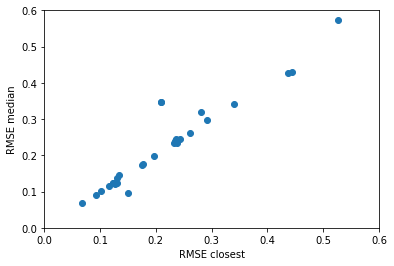

In [357]:
plt.scatter(df_cm_closest['RMSE'], df_cm['RMSE'])
plt.xlim(0,.6)
plt.ylim(0,.6)
plt.ylabel("RMSE median")
plt.xlabel("RMSE closest")

Text(0.5, 0, 'RMSE closest')

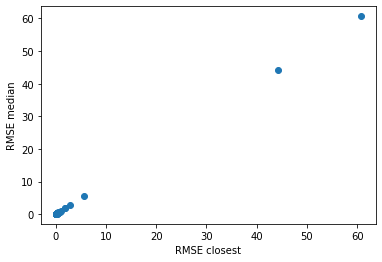

In [355]:
plt.scatter(df_cm_closest['RMSE'], df_cm['RMSE'])
# plt.xlim(0,.75)
# plt.ylim(0,.75)
plt.ylabel("RMSE median")
plt.xlabel("RMSE closest")

In [376]:
df_cm_closest.shape

(36, 19)

In [375]:
df_cm.shape

(36, 19)

In [383]:
df_comp=df_cm_closest[['lake_name', 'altis','RHO', 'RMSE']].set_index('altis').join(df_cm[['lake_name', 'altis','RHO', 'RMSE']].set_index('altis'), lsuffix='_cl',rsuffix='_md', on='altis').reset_index()
df_comp

,altis,lake_name_cl,RHO_cl,RMSE_cl,lake_name_md,RHO_md,RMSE_md
0,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,Lago Mascardi,0.924263,0.093222,Lago Mascardi,0.922702,0.091566
1,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,Lago Rosario,0.696245,0.123315,Lago Rosario,0.695427,0.124433
2,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,Lago Lacar,0.911800,0.232510,Lago Lacar,0.910803,0.233007
3,AlTiS_TimeSeries_Sentinel-3B_0020_S4492,Lago Fontana,0.921444,0.150841,Lago Fontana,0.923853,0.097003
4,AlTiS_TimeSeries_Sentinel-3A_0676_S4325,Lago Rosario,0.650494,0.174575,Lago Rosario,0.658430,0.174604
5,AlTiS_TimeSeries_Sentinel-3A_0749_S4016,Lago Lacar,0.966177,0.116816,Lago Lacar,0.968995,0.115166
6,AlTiS_TimeSeries_Jason-3_0215_S4017,Lago Lacar,0.894436,0.260788,Lago Lacar,0.892176,0.261734
7,AlTiS_TimeSeries_Sentinel-3B_0622_N4234,Grays Lake,0.017580,0.340111,Grays Lake,-0.015488,0.342035
8,AlTiS_TimeSeries_Sentinel-3A_0035_N3493,Catfish Lake,0.669462,0.130237,Catfish Lake,0.669462,0.122809
9,AlTiS_TimeSeries_Sentinel-3A_0636_N2354,Balashur,0.607143,0.525670,Balashur,0.571429,0.574353


In [389]:
df_comp.loc[(df_comp['RHO_cl']>df_comp['RHO_md'])&(df_comp['RMSE_cl']<df_comp['RMSE_md'])]

,altis,lake_name_cl,RHO_cl,RMSE_cl,lake_name_md,RHO_md,RMSE_md
1,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,Lago Rosario,0.696245,0.123315,Lago Rosario,0.695427,0.124433
2,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,Lago Lacar,0.911800,0.232510,Lago Lacar,0.910803,0.233007
6,AlTiS_TimeSeries_Jason-3_0215_S4017,Lago Lacar,0.894436,0.260788,Lago Lacar,0.892176,0.261734
7,AlTiS_TimeSeries_Sentinel-3B_0622_N4234,Grays Lake,0.017580,0.340111,Grays Lake,-0.015488,0.342035
9,AlTiS_TimeSeries_Sentinel-3A_0636_N2354,Balashur,0.607143,0.525670,Balashur,0.571429,0.574353
10,AlTiS_TimeSeries_Sentinel-3B_0549_N4183,Silver Lake,0.641477,0.197380,Silver Lake,0.625660,0.197609
15,AlTiS_TimeSeries_Sentinel-3A_0522_N2294,Khajura Baor,0.576600,0.235957,Khajura Baor,0.428571,0.245505
22,AlTiS_TimeSeries_Sentinel-3A_0261_S0424,Açude Araras,0.928273,2.729777,Açude Araras,0.928267,2.730675
23,AlTiS_TimeSeries_Sentinel-3A_0104_S0424,Açude Araras,0.974617,1.853919,Açude Araras,0.973947,1.856586
25,AlTiS_TimeSeries_Sentinel-3A_0190_S2751,UHE Machadinho,0.997155,0.209857,UHE Machadinho,0.994784,0.347699


In [385]:
df_comp.loc[(df_comp['RMSE_cl']>df_comp['RMSE_md'])]

,altis,lake_name_cl,RHO_cl,RMSE_cl,lake_name_md,RHO_md,RMSE_md
0,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,Lago Mascardi,0.924263,0.093222,Lago Mascardi,0.922702,0.091566
3,AlTiS_TimeSeries_Sentinel-3B_0020_S4492,Lago Fontana,0.921444,0.150841,Lago Fontana,0.923853,0.097003
5,AlTiS_TimeSeries_Sentinel-3A_0749_S4016,Lago Lacar,0.966177,0.116816,Lago Lacar,0.968995,0.115166
8,AlTiS_TimeSeries_Sentinel-3A_0035_N3493,Catfish Lake,0.669462,0.130237,Catfish Lake,0.669462,0.122809
11,AlTiS_TimeSeries_Sentinel-3A_0193_N2515,Tanguar Haor,0.833333,0.775897,Tanguar Haor,0.833333,0.765798
13,AlTiS_TimeSeries_Sentinel-3A_0026_N4756,Lake Sammamish,0.812745,0.176713,Lake Sammamish,0.810480,0.176415
16,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,Lake Mattamuskeet West,0.376360,0.127282,Lake Mattamuskeet West,0.389521,0.120955
17,AlTiS_TimeSeries_Sentinel-3A_0149_N3577,Lake Phelps,0.470742,0.101472,Lake Phelps,0.448847,0.100471
20,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0424,Açude Araras,0.993372,1.015873,Açude Araras,0.993391,1.014719
21,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,Açude Araras,0.967308,1.756349,Açude Araras,0.967308,1.756206


<AxesSubplot:xlabel='RHO_cl', ylabel='RHO_md'>

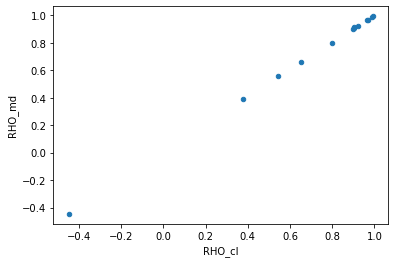

In [394]:
df_comp.loc[(df_comp['RHO_cl']<df_comp['RHO_md'])].plot.scatter('RHO_cl','RHO_md')

In [393]:
df_comp.loc[(df_comp['RHO_cl']<df_comp['RHO_md'])].scatter('RHO_cl','RHO_md')

AttributeError: 'DataFrame' object has no attribute 'scatter'

In [388]:
df_comp.loc[(df_comp['RHO_cl']<df_comp['RHO_md'])&(df_comp['RMSE_cl']>df_comp['RMSE_md'])]

,altis,lake_name_cl,RHO_cl,RMSE_cl,lake_name_md,RHO_md,RMSE_md
3,AlTiS_TimeSeries_Sentinel-3B_0020_S4492,Lago Fontana,0.921444,0.150841,Lago Fontana,0.923853,0.097003
5,AlTiS_TimeSeries_Sentinel-3A_0749_S4016,Lago Lacar,0.966177,0.116816,Lago Lacar,0.968995,0.115166
16,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,Lake Mattamuskeet West,0.376360,0.127282,Lake Mattamuskeet West,0.389521,0.120955
20,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0424,Açude Araras,0.993372,1.015873,Açude Araras,0.993391,1.014719
21,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,Açude Araras,0.967308,1.756349,Açude Araras,0.967308,1.756206
24,AlTiS_TimeSeries_Jason-3_0011_S2599,Ney Aminthas de Barro,0.902161,0.444978,Ney Aminthas de Barro,0.911894,0.429313
32,AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765,Açude Atalho,0.988696,0.437109,Açude Atalho,0.989565,0.426054
34,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,Rathbun Lake,0.897638,0.237805,Rathbun Lake,0.897937,0.233451


Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Lake ID: 1824 ground_st: True df_altis: (73, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Lake ID: 2028 ground_st: True df_altis: (77, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN Lake ID: 2028 ground_st: True df_altis: (104, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN Lake ID: 2028 ground_st: True df_altis: (157, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2234 ground_st: True df_altis: (76, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2234 ground_st: True df_altis: (75, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2316 ground_st: True df_altis: (41, 8)
Station America/Edmonton ncolgeoid: GEOID_01_MEDIAN Lake ID: HMT2 ground_st: True df_altis: (73, 8)
Station America/New_York ncolgeoid: GEOID_01_MEDIAN Lake ID: MTN2 ground_st: True df_altis: (44, 8)
Station Asia/Dhaka ncolgeoid: GEO

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Station America/Recife ncolgeoid: GEOID_01_MEDIAN Lake ID: 12056 ground_st: True df_altis: (7, 8)
Station America/Maceio ncolgeoid: GEOID_01_MEDIAN Lake ID: 19126 ground_st: True df_altis: (37, 8)
Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN Lake ID: 19069 ground_st: True df_altis: (37, 8)
Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN Lake ID: 19069 ground_st: True df_altis: (37, 8)
Station America/Sao_Paulo ncolgeoid: GEOID_EIGEN6C4D_MEDIAN Lake ID: 19060 ground_st: True df_altis: (106, 8)
Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN Lake ID: 19060 ground_st: True df_altis: (52, 8)
Station America/Fortaleza ncolgeoid: GEOID_MEDIAN Lake ID: 12036 ground_st: True df_altis: (205, 8)
Station America/Fortaleza ncolgeoid: GEOID_01_MEDIAN Lake ID: 12036 ground_st: True df_altis: (42, 8)
Station America/Fortaleza ncolgeoid: GEOID_MEDIAN Lake ID: 12030 ground_st: True df_altis: (211, 8)
Station America/Fortaleza ncolgeoid: GEOID_MEDIAN Lake ID: 12030 ground_st: True df_a

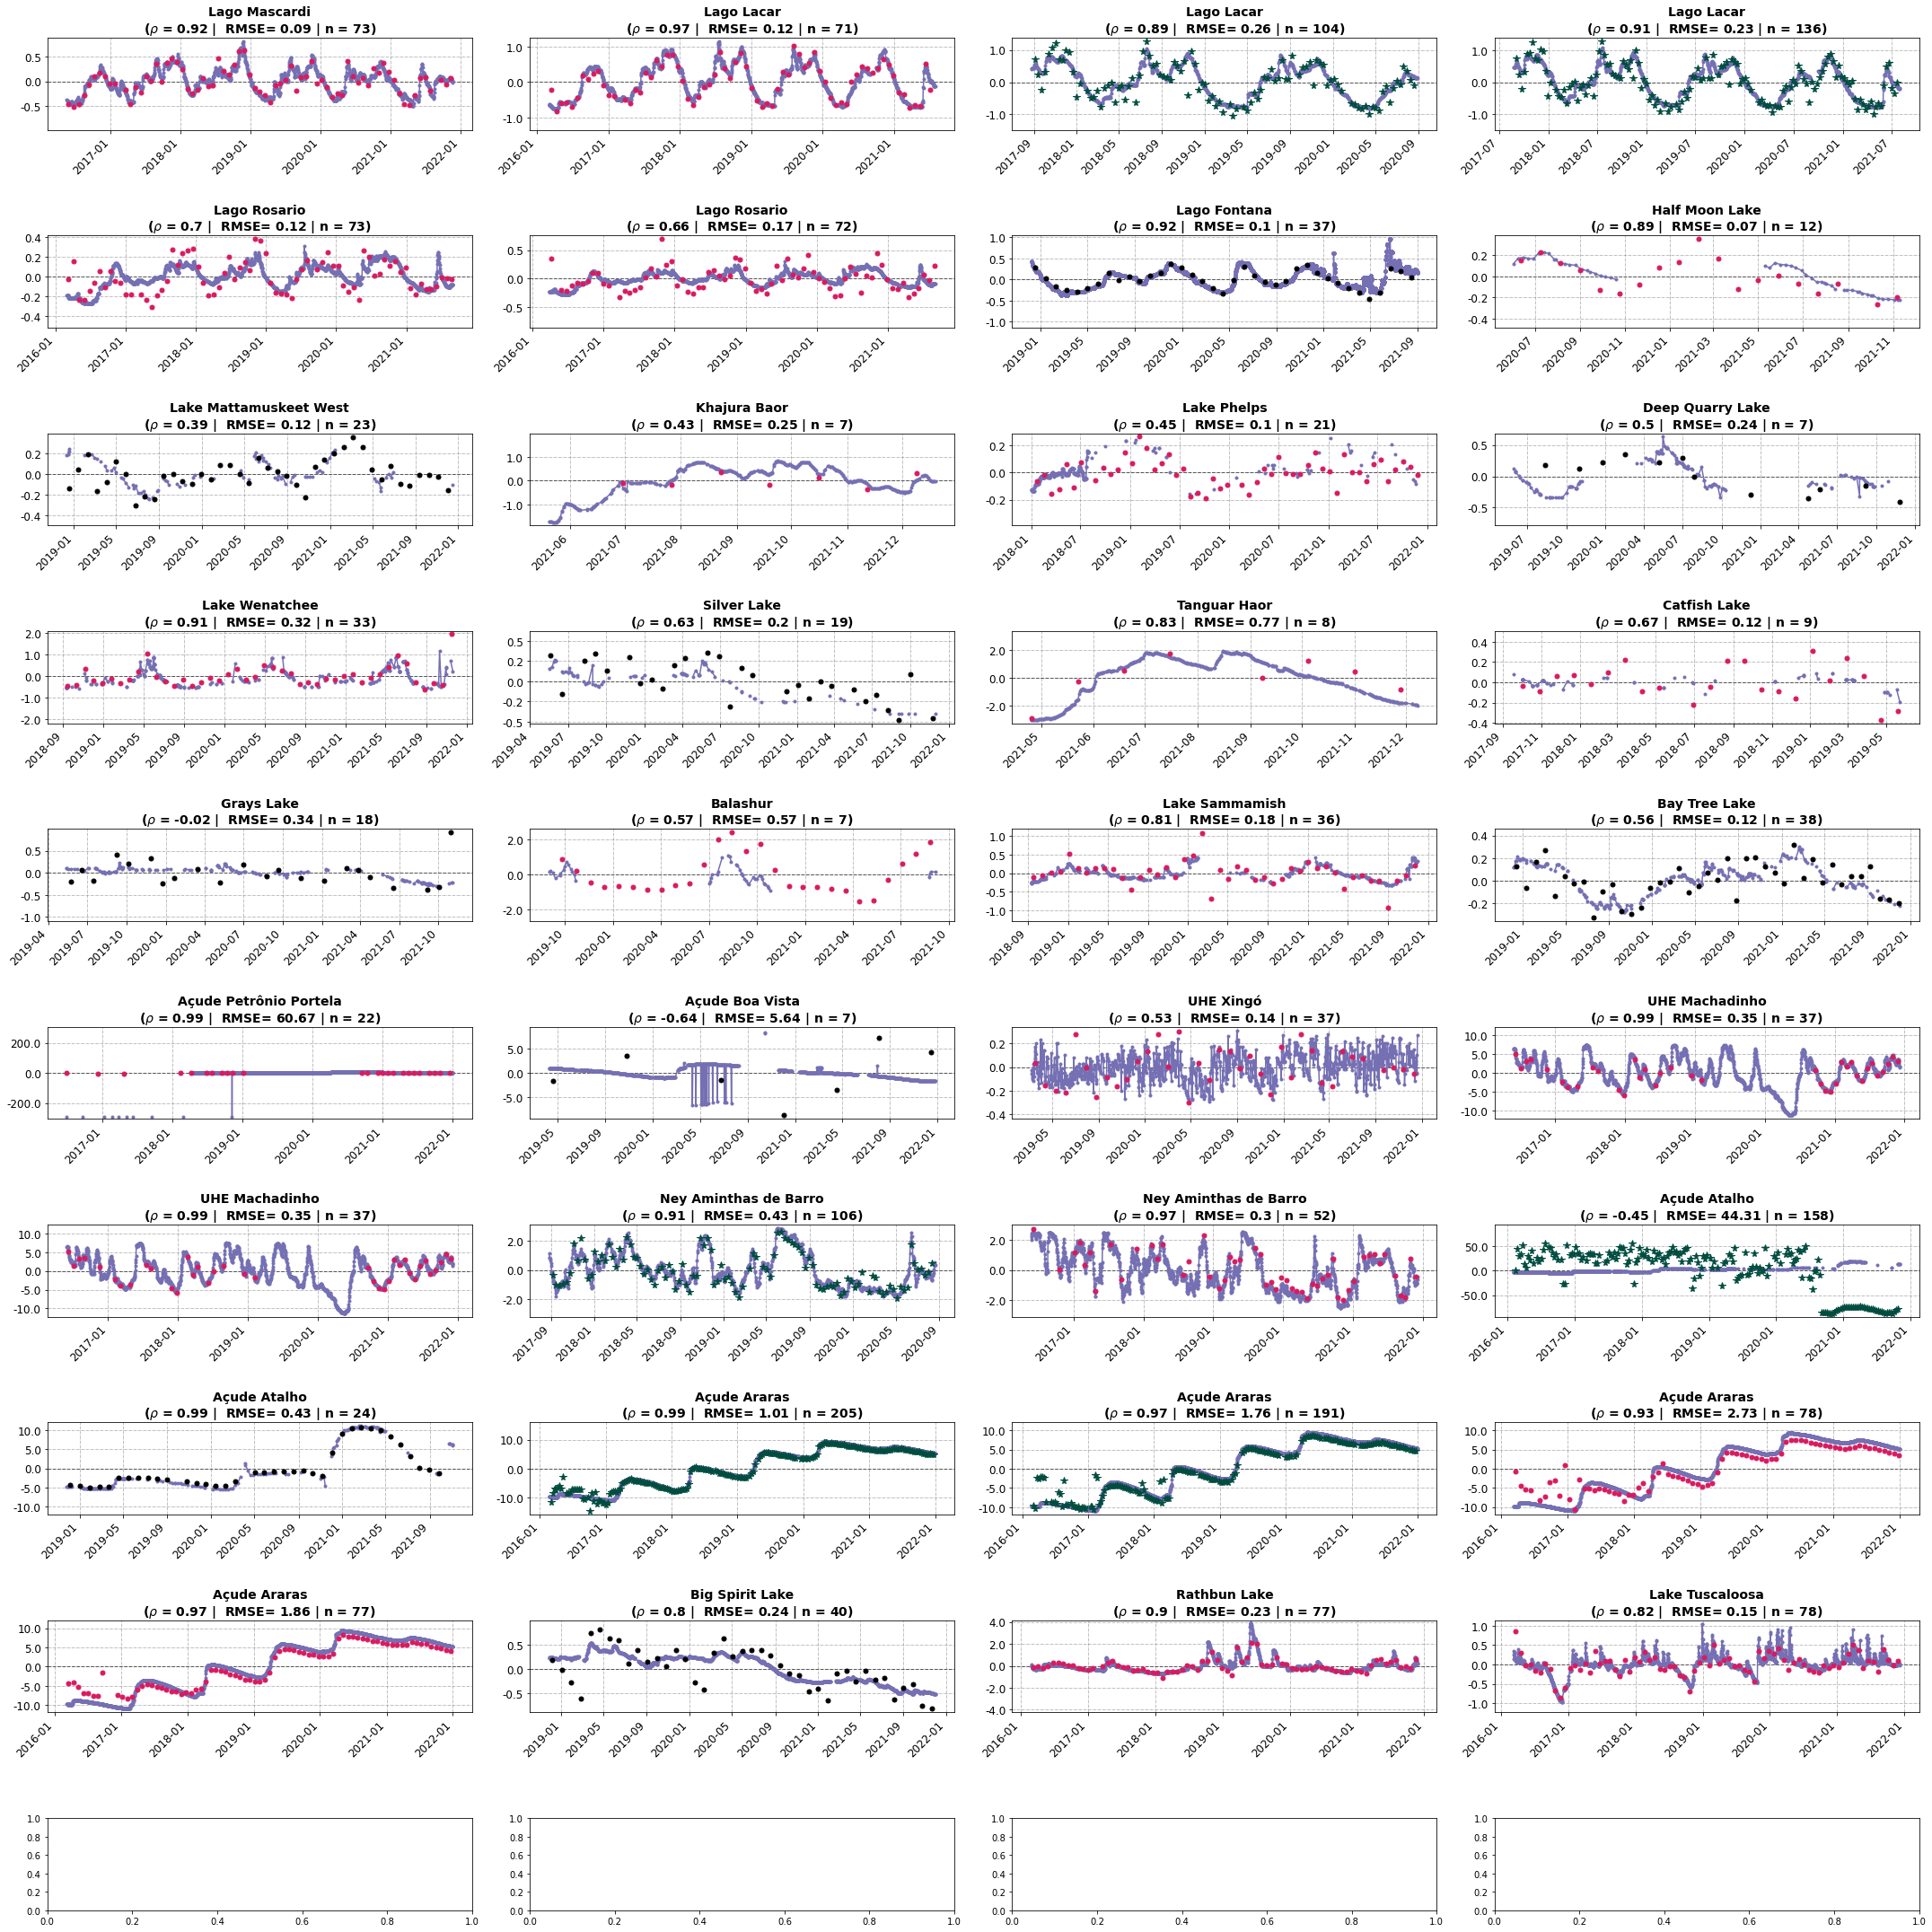

'Deep quarry freeze Sylver probably freez Half Moon too. Grays does freeze '

In [89]:
# #Test to determine potential number of figures
# path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'


# if platform.system()=='Linux':
#     altis_csv=pd.read_csv(path, sep=',',encoding='iso-8859-1')
# else:
#     altis_csv=pd.read_csv(path, sep=',', encoding='windows-1252')  


# altis_csv.shape

# #Read each file and convert it to dataframe
# g_path='../data/alti_timeseries/'

# time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
# # path_name='../data/results/plots_mv_'+time_fig+'/'

# # if save_plot:
# #     output_f=path_name
# # else:
# #     output_f=None

# if start==0:
#     df_final_altis=pd.DataFrame()
#     df_final_ground=pd.DataFrame()
#     df_cm=pd.DataFrame()
    

# # path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
# lon_fd='lon'
# lat_fd='lat'


# tf=TimezoneFinder()

# #Filter to lakes approved
# #---------------------------

# approve_locss=df_sel_lakes.loc[df_sel_lakes['AprovedFor']==1]['gauge_id'].values #['HMT2','PHN2','SAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','KHB2']
# altis_csv=altis_csv.loc[altis_csv['station_id'].isin(approve_locss)]

# #----------------------------------------

# df_gts=df_ground_ts.copy()

# st_fd='gauge_id'
# st_date_fd='date'
# altis_date_fd = 'date'  # Same value for Sentinel-3A/B
# altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
# nodataalti=-9999

# wse_ref='e'

# i=1
# #################CHANGE WITH N COMPARISON ####################
# #----ALL
# row_f=10
# col_f=4
# w=30
# h=30
# this_source='ALL'

# #----ARHN
# # row_f=2
# # col_f=4
# # w=15
# # h=10
# # this_source='ARHN'

# ##---LOCSS
# # row_f=5
# # col_f=3
# # w=25
# # h=20
# # this_source='LOCSS'

# #---USGS
# # row_f=3
# # col_f=1
# # w=15
# # h=18
# # this_source='USGS'

# ##----RVBR
# # row_f=5
# # col_f=3
# # w=30
# # h=15
# # this_source='RVBR'

# #-----ICECV

# # row_f=4
# # col_f=4
# # w=20
# # h=15
# # this_source='ICECV'
# ###########################################################
# if this_source not in ['ALL', 'ICECV']:
#     altis_csv=altis_csv.loc[altis_csv['source']==this_source].copy()

# data_source=this_source

# altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
# #filter only altis time series with ground observations
# altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]

# fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
# axs=axs.ravel()
# x_ax=0
# y_ax=0
# c=0
# altis_w_gts_csv=altis_w_gts_csv.sort_values(by='source')
# for index,row in altis_w_gts_csv.iterrows():
#     # print(row['station_id'])
#     altis_name=row['altivs_nam']
#     st_id=row['station_id']
#     ncolgeoid=row['ncolgeoid']
#     # Call every altis relative to the ellipsoide
    
#     # is_Sentinel=altis_name.find('Sentinel-3')
#     # if is_Sentinel!=-1:
#     if ncolgeoid!='No':
#         #Call the function with geoid field and wse_type='e'
#         df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,
#                                                         nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
#     else:
#         #Call the function with geoid field and wse_type='g'
#         df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
#     print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), 'Lake ID: '+st_id+' ground_st: '+str(not df_ground_st.empty)+' df_altis: '+str(df_altis.shape))
#     # print(df_altis.columns)
#     if not df_ground_st.empty:
#         # print('df_altis\n', df_altis.head(3))
#         # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
#         df_altis[st_fd]=st_id
#         lake_name=df_ground_st['lake_name'].iloc[0]
#         #Convert time in df_gts_st to UTC
#         source=df_ground_st['source'].iloc[0]
        
#         df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        
#         #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
#         df_ground_st['altis_d_1']=altis_name
        
#         #Get the dates of altis
#         # ic(df_altis[altis_date_fd].dt.normalize().max())
#         (df_altis_c, df_ground_c)=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
#                                                     date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=True, ndays=10)

# #         
        
#         if source=='USGS':
#             df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=False)
#         else:
#             df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=True)
#         #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
#         df_ground_c=df_ground_c.sort_values(by=['decimal_y'])
#         df_altis_c=df_altis_c.sort_values(by=['decimal_y'])
#         # print(df_altis_c.head())
#         delta=5
#         median_fd='median_d_'+str(delta)
#         mean_fd='mean_d_'+str(delta)
#         std_fd='std_d_'+str(delta)
#         count_fd='count_d_'+str(delta)
        
       
#         #Get moving windows
#         df_altis_c[[median_fd,mean_fd, std_fd,count_fd]]=df_altis_c.apply(lambda x: moving_window_around_date(df_ground_c,
#                                                                                                               x[altis_date_fd],
#                                                                                                               delta,
#                                                                                                               'height',
#                                                                                                               'date_utc'), axis=1).apply(pd.Series)

        
#         metrics=get_comp_metrics(ts_obs=df_altis_c[median_fd].to_numpy(),ts_est=df_altis_c['height'].to_numpy())
        
#         #Add coef variation of the observations
        
#         cv=np.nanstd(df_altis_c[median_fd].to_numpy())/np.nanmean(df_altis_c[median_fd].to_numpy())*100
#         std_obs=np.nanstd(df_altis_c[median_fd].to_numpy())
#         mean_obs=np.nanmean(df_altis_c[median_fd].to_numpy())
        
#         # ic(st_id,std_obs,mean_obs)
#         # if mean_obs is np.nan:
#         # ic(df_altis_c[median_fd].to_numpy())
#             # break

#         # Add to the output dataframe the range of dates of analysis in UTC
#         altis_min_utc_date=df_altis_c['date'].dt.normalize().min()
#         altis_max_utc_date=df_altis_c['date'].dt.normalize().max()
#         ground_min_utc_date=df_ground_c['date'].dt.normalize().min()
#         ground_max_utc_date=df_ground_c['date'].dt.normalize().max()
#         #ic(altis_min_utc_date,altis_max_utc_date,ground_min_utc_date,ground_max_utc_date)
        
#         #Create a output dataframe with the metrics
#         cm_dict={'station':[st_id],'lake_name':lake_name, 'altis':[altis_name], 'source':[source], 'method':['Moving Window'],
#                 'R':metrics['PR'],'PR_pvalue':metrics['PR_p_val'],'RHO':metrics['RHO'],'RHO_pvalue':metrics['RHO_p_val'],'NSF':metrics['NSF'],'RMSE':metrics['RMSE_ts2'],'APL':metrics['ampl_ts1'],
#                 'ME':metrics['me'],'VE':metrics['ve'], 'number_obs':metrics['size_obs'],'number_altis':metrics['size_est'],'cv_obs':cv,
#                 'sat_min_utcdate':altis_min_utc_date,'sat_max_utcdate':altis_max_utc_date,'grd_min_utcdate':ground_min_utc_date,'grd_max_utcdate':ground_max_utc_date}
        
        
#         df_cmi=pd.DataFrame(cm_dict)
        
#         df_cm=pd.concat((df_cm,df_cmi), axis=0)
#         df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
#         df_final_ground=pd.concat((df_final_ground,df_ground_c), axis=0)
#         # print('error', me_alti_insi)
#         #Superscript https://stackoverflow.com/questions/21226868/superscript-in-python-plots
#         error_m_text='\n($\\rho$ = '+str(np.round(cm_dict['RHO'], decimals=2))+' | '+\
#         ' RMSE= '+str(np.round(cm_dict['RMSE'],decimals=2))+' | n = '+str(cm_dict['number_obs'])+')'#+\
#         # 'VE: '+str(np.round(ve_alti_insi, decimals=4))

#         labels=altis_name.split('_')[2]
#         # labelg=' '+st_id
#         labelg=lake_name
#         labeli='Interp ground to altis'

        

#         dfg=df_ground_c
#         dfs=df_altis_c

#         # dic_intp={'decimal_y':df_altis_plot['decimal_y'].to_numpy(), 'height':inh_2_altidy}


#         date_plot_fd='date'#'decimal_y'
#         height_plot_fd='height'
#         nfig=i
#         if show_plot:
#             #Add ice covered
#             fill_between=None #{'fill':'SLIDE_snowIce',
#                               #'lim':0.5}
#             plt.subplot(row_f,col_f,nfig)
# #             https://stackoverflow.com/questions/62443158/plots-not-working-in-for-loop-i-am-getting-only-the-last-element-plot

#             plot_dev_mean_publish(nfig,dfs, dfg, source, st_id, altis_name, date_plot_fd, height_plot_fd, labels, labelg, fill_between, error_m_text)
#         i=i+1
# if save_plot:     
#     plt.savefig('../data/results/'+data_source+'_'+time_fig+'_all_icgt0.pdf')#, dpi=300, format='svg')    
#     print('Figure save to:\n','../data/results/'+data_source+'_'+time_fig+'_all_icgt0.pdf')
# if show_plot:
#     plt.show() 

# df_final_altis['method']='Moving Window'
# df_final_ground['method']='Moving Window'


# #Save results
# if save_res:
#     # ic(df_cm.head())
#     #Save comparison metrics 
#     df_cm['R']=[np.round(v, decimals=3) for v in df_cm['R']]
#     df_cm['RHO']=[np.round(v, decimals=3) for v in df_cm['RHO']]
#     df_cm['NSF']=[np.round(v, decimals=3) for v in df_cm['NSF']]
#     df_cm['RMSE']=[np.round(v, decimals=3) for v in df_cm['RMSE']]
#     df_cm['APL']=[np.round(v, decimals=3) for v in df_cm['APL']]
#     df_cm['ME']=[np.round(v, decimals=3) for v in df_cm['ME']]
#     df_cm['VE']=[np.round(v, decimals=3) for v in df_cm['VE']]
#     df_cm['n_obs']=[np.round(v, decimals=3) for v in df_cm['number_obs']]
#     df_cm['cv_obs']=[np.round(v, decimals=3) for v in df_cm['cv_obs']]
#     #df_cm['sat_min_utcdate']=df_cm['sat_min_utcdate'].dt.stfrtime()
# #     df_cm['sat_max_utcdate']=:altis_max_utc_date,
# #     df_cm['grd_min_utcdate']=:ground_min_utc_date,
# #     df_cm['grd_max_utcdate']=:ground_max_utc_date}
    
#     cols=['station', 'altis', 'source', 'method','R','PR_pvalue','RHO','RHO_pvalue','NSF','RMSE', 'APL', 'VE','cv_obs', 'n_obs','sat_min_utcdate','sat_max_utcdate', 'grd_min_utcdate','grd_max_utcdate']     
#     df_cm[cols].to_csv('../data/results/comparison_'+this_source+'_'+time_fig+'.csv', sep=',')
#     print('Data save to:\n','../data/results/comparison_'+this_source+'_'+time_fig+'.csv')

# '''Deep quarry freeze Sylver probably freez Half Moon too. Grays does freeze '''

In [107]:
df_final_altis.columns

Index(['decimal_y', 'height', 'year', 'month', 'day', 'hour', 'date',
       'name_altis', 'ground_st_1', 'median_d_5', 'mean_d_5', 'std_d_5',
       'count_d_5', 'method'],
      dtype='object')

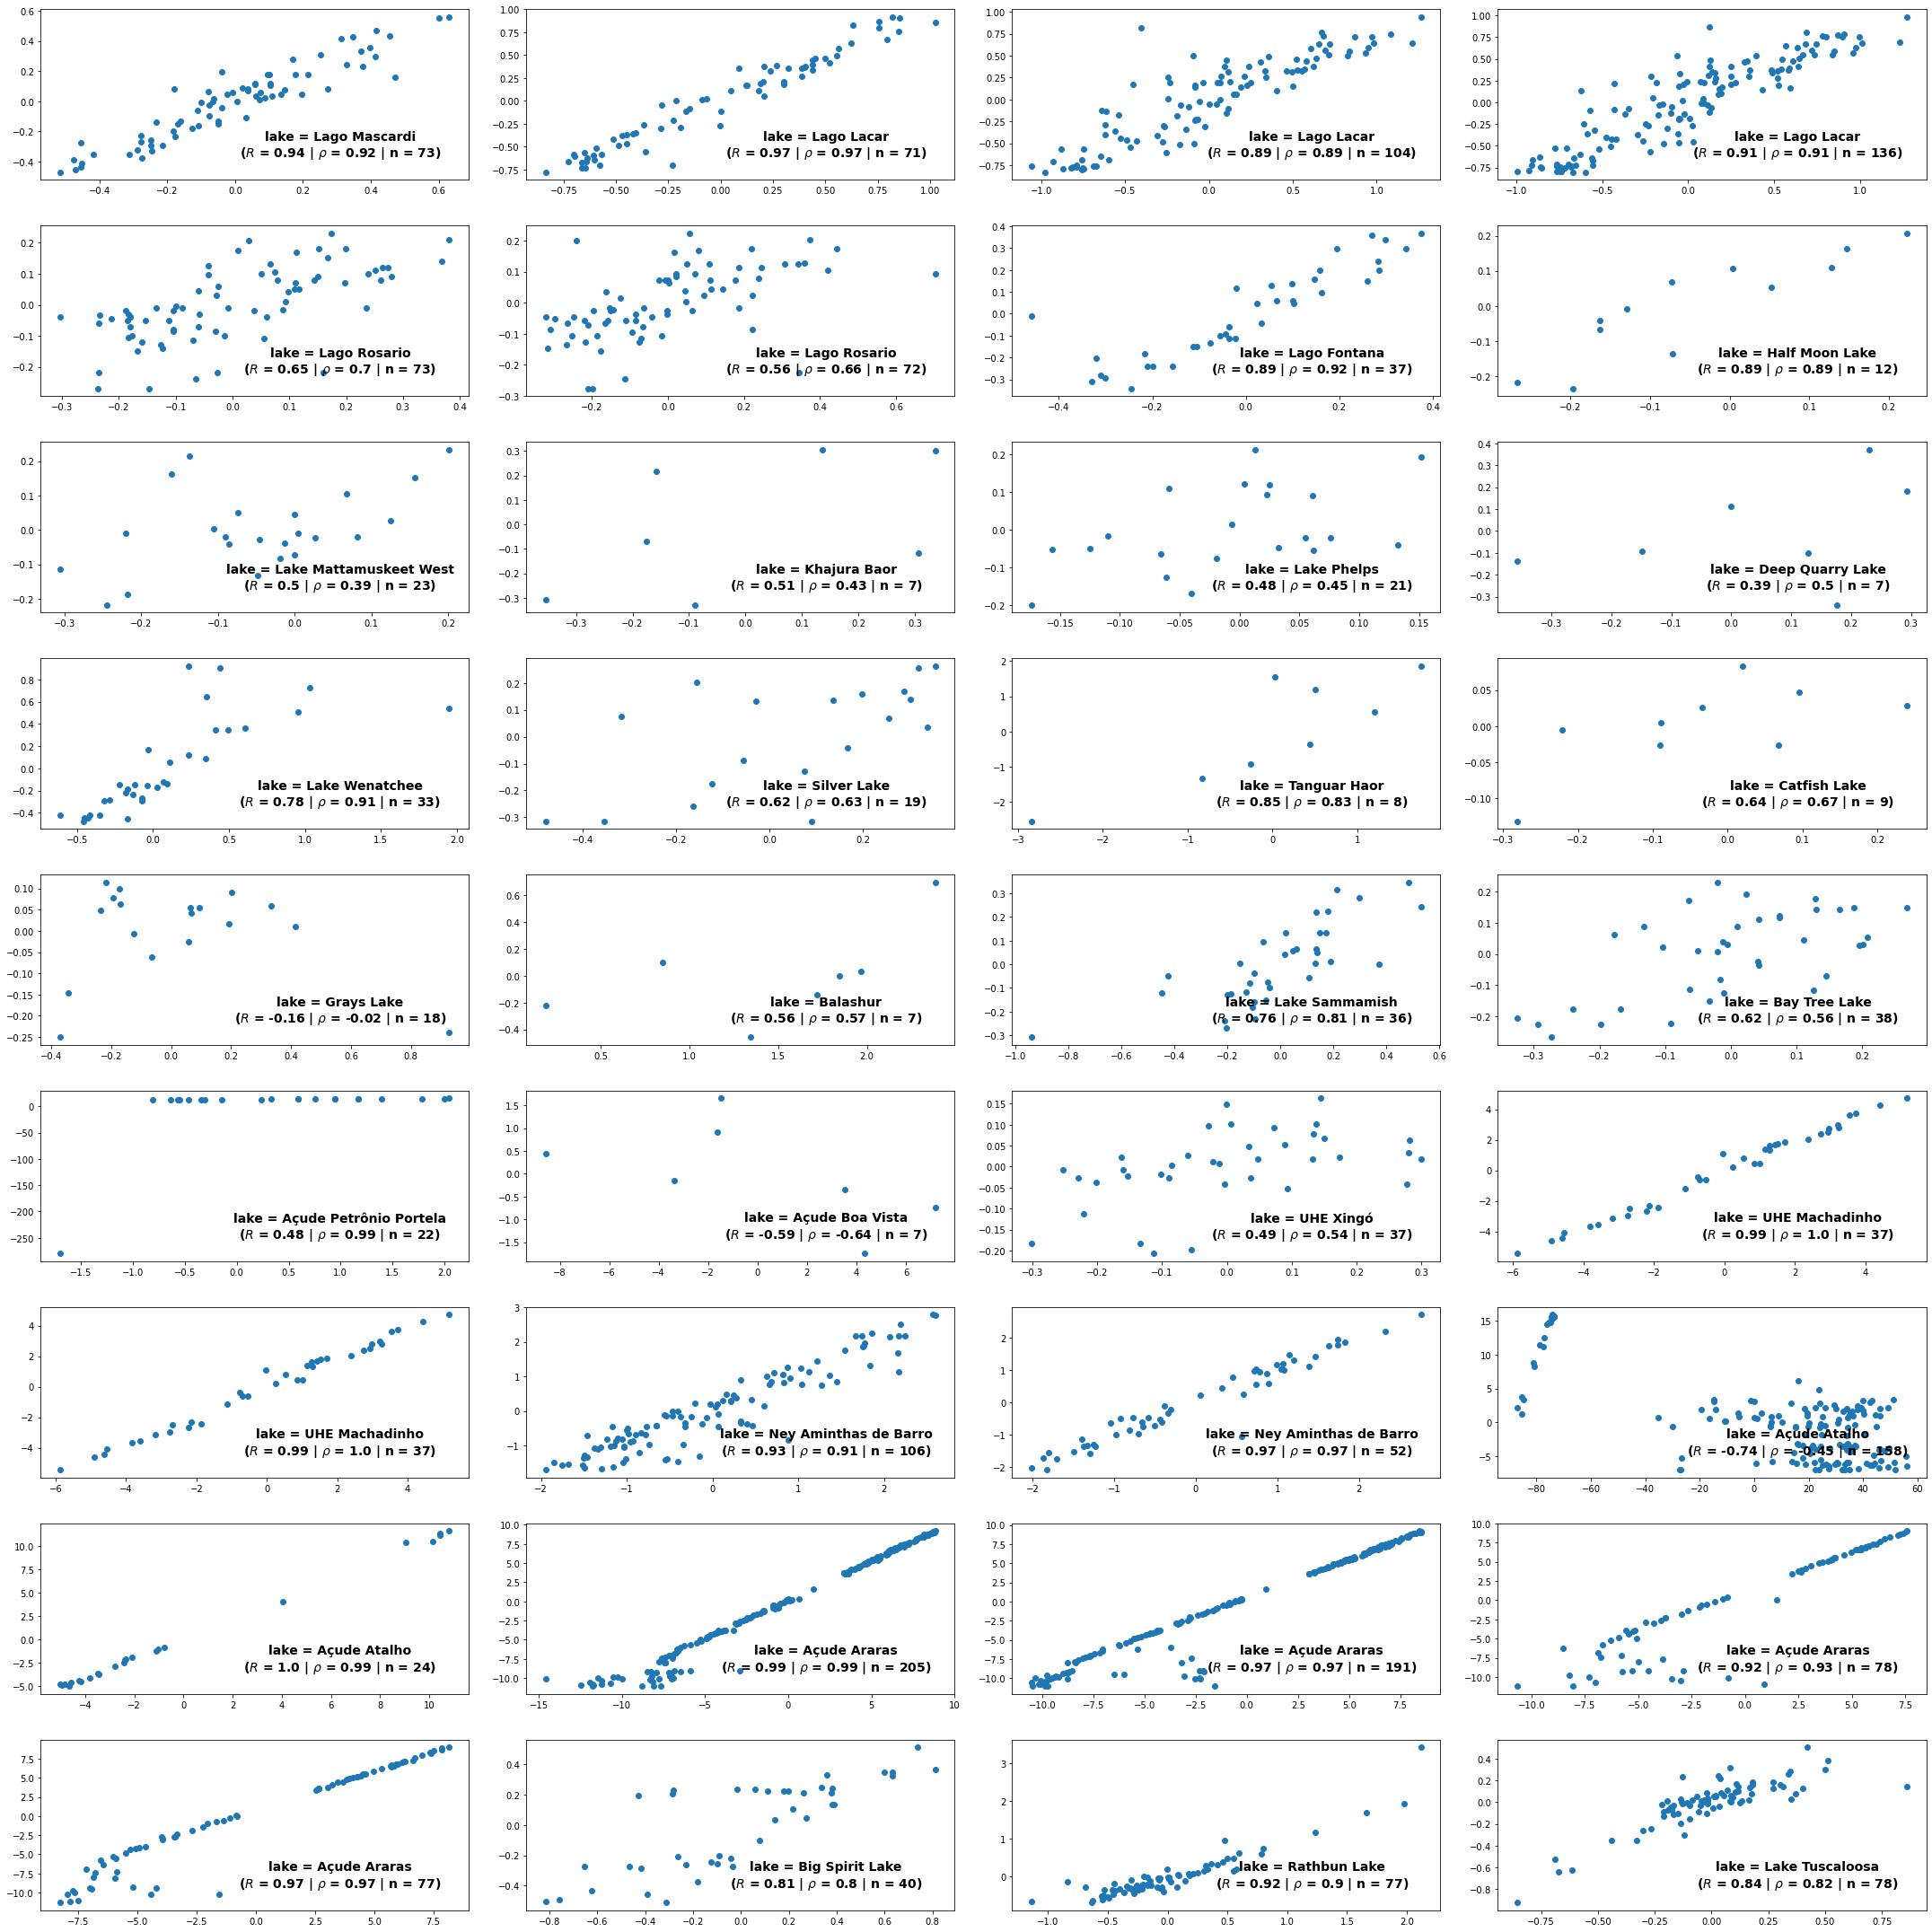

In [59]:
om='AlTiS_TimeSeries_Sentinel-3A_0562_S4128'
df_final_altis.columns


i=0
j=0
row_f=9
col_f=4
w=30
h=30
this_source='ALL'
fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
for om in df_final_altis['name_altis'].unique():
    df_val=df_final_altis.loc[df_final_altis['name_altis']==om]
    df_val
    df_metrics=df_cm.loc[df_cm['altis']==om]
    # ic(df_metrics)
    error_m_text='lake = '+df_metrics['lake_name'].iloc[0]+'\n($R$ = '+str(np.round(df_metrics['R'].iloc[0], decimals=2))+' | '+\
       '$\\rho$ = '+str(np.round(df_metrics['RHO'].iloc[0],decimals=2))+' | n = '+str(df_metrics['n_obs'].iloc[0])+')'#+\
    # df_final_ground.columns
    # fig, ax = plt.subplots()
    # plt.subplot(row_f,col_f,nfig)
    #Observed Vs Estimates
    axs[i][j].scatter(df_val['height']-np.mean(df_val['height']),df_val['median_d_5']-np.mean(df_val['median_d_5']))#, linestyle=None, marker='o')
    fig.tight_layout(h_pad=3, w_pad=2)
    axs[i][j].text(0.7,0.2,error_m_text, fontsize=14,weight='bold',
                   horizontalalignment='center', verticalalignment='center', transform=axs[i][j].transAxes)
    if j>=col_f-1:
        j=0
        if i<=row_f-1:
            i=i+1
    else:
        j=j+1
    
# axs.legend()


In [67]:
df_final_altis.columns

Index(['Unnamed: 0', 'decimal_y', 'height', 'year', 'month', 'day', 'hour',
       'date', 'name_altis', 'gauge_id', 'median_d_5', 'mad_d_5', 'mean_d_5',
       'std_d_5', 'count_d_5', 'val_cd_d_5', 'type_cd_d_5', 'ndays_cd_d_5',
       'mea_cd_d_5', 'mad_cd_d_5', 'std_cd_d_5', 'n_cd_d_5', 'lake_name',
       'source'],
      dtype='object')

In [69]:
#Calculate metric lake variability
#using Eq 2http://wwwapp.epa.state.oh.us/dsw/nps/NPSMP/docs/JAWRA_03095_Baker.pdf

for orbit in df_final_altis['name_altis'].unique():
    df=df_final_altis.loc[df_final_altis['name_altis']==orbit].copy()
    
    df['diff_obs']=np.abs(df[val_fd].diff())
    sum_swe=df[val_fd].sum()
    diff_swe=df['diff_obs'].sum()
    rb_index=diff_swe/sum_swe
    df_cm.loc[df_cm['altis']==orbit, 'rb_index']=rb_index
    ic(df['gauge_id'].unique()[0], rb_index)
    
    


ic| df['gauge_id'].unique()[0]: '2028', rb_index: 0.10869482423734621
ic| df['gauge_id'].unique()[0]: '2028', rb_index: 0.11008292272563391
ic| df['gauge_id'].unique()[0]: '1824', rb_index: 0.12672691388802326
ic| df['gauge_id'].unique()[0]: '2234', rb_index: 0.06471111111111112
ic| df['gauge_id'].unique()[0]: '2234', rb_index: 0.0664167113015533
ic| df['gauge_id'].unique()[0]: '2028', rb_index: 0.2389045115539797
ic| df['gauge_id'].unique()[0]: '2316', rb_index: 0.18536197295147175
ic| df['gauge_id'].unique()[0]: 'MTN2', rb_index: 0.08362922112261086
ic| df['gauge_id'].unique()[0]: 'FDN2', rb_index: 0.007059267648169119
ic| df['gauge_id'].unique()[0]: 'YSL2', rb_index: 0.07931225734886295
ic| df['gauge_id'].unique()[0]: 'QUL2', rb_index: 0.2056555269922879
ic| df['gauge_id'].unique()[0]: 'SLL2', rb_index: 0.1184008200922604
ic| df['gauge_id'].unique()[0]: 'WEW2', rb_index: 0.39638258736971177
ic| df['gauge_id'].unique()[0]: 'BTN2', rb_index: 0.11812008577555395
ic| df['gauge_id'].uniq

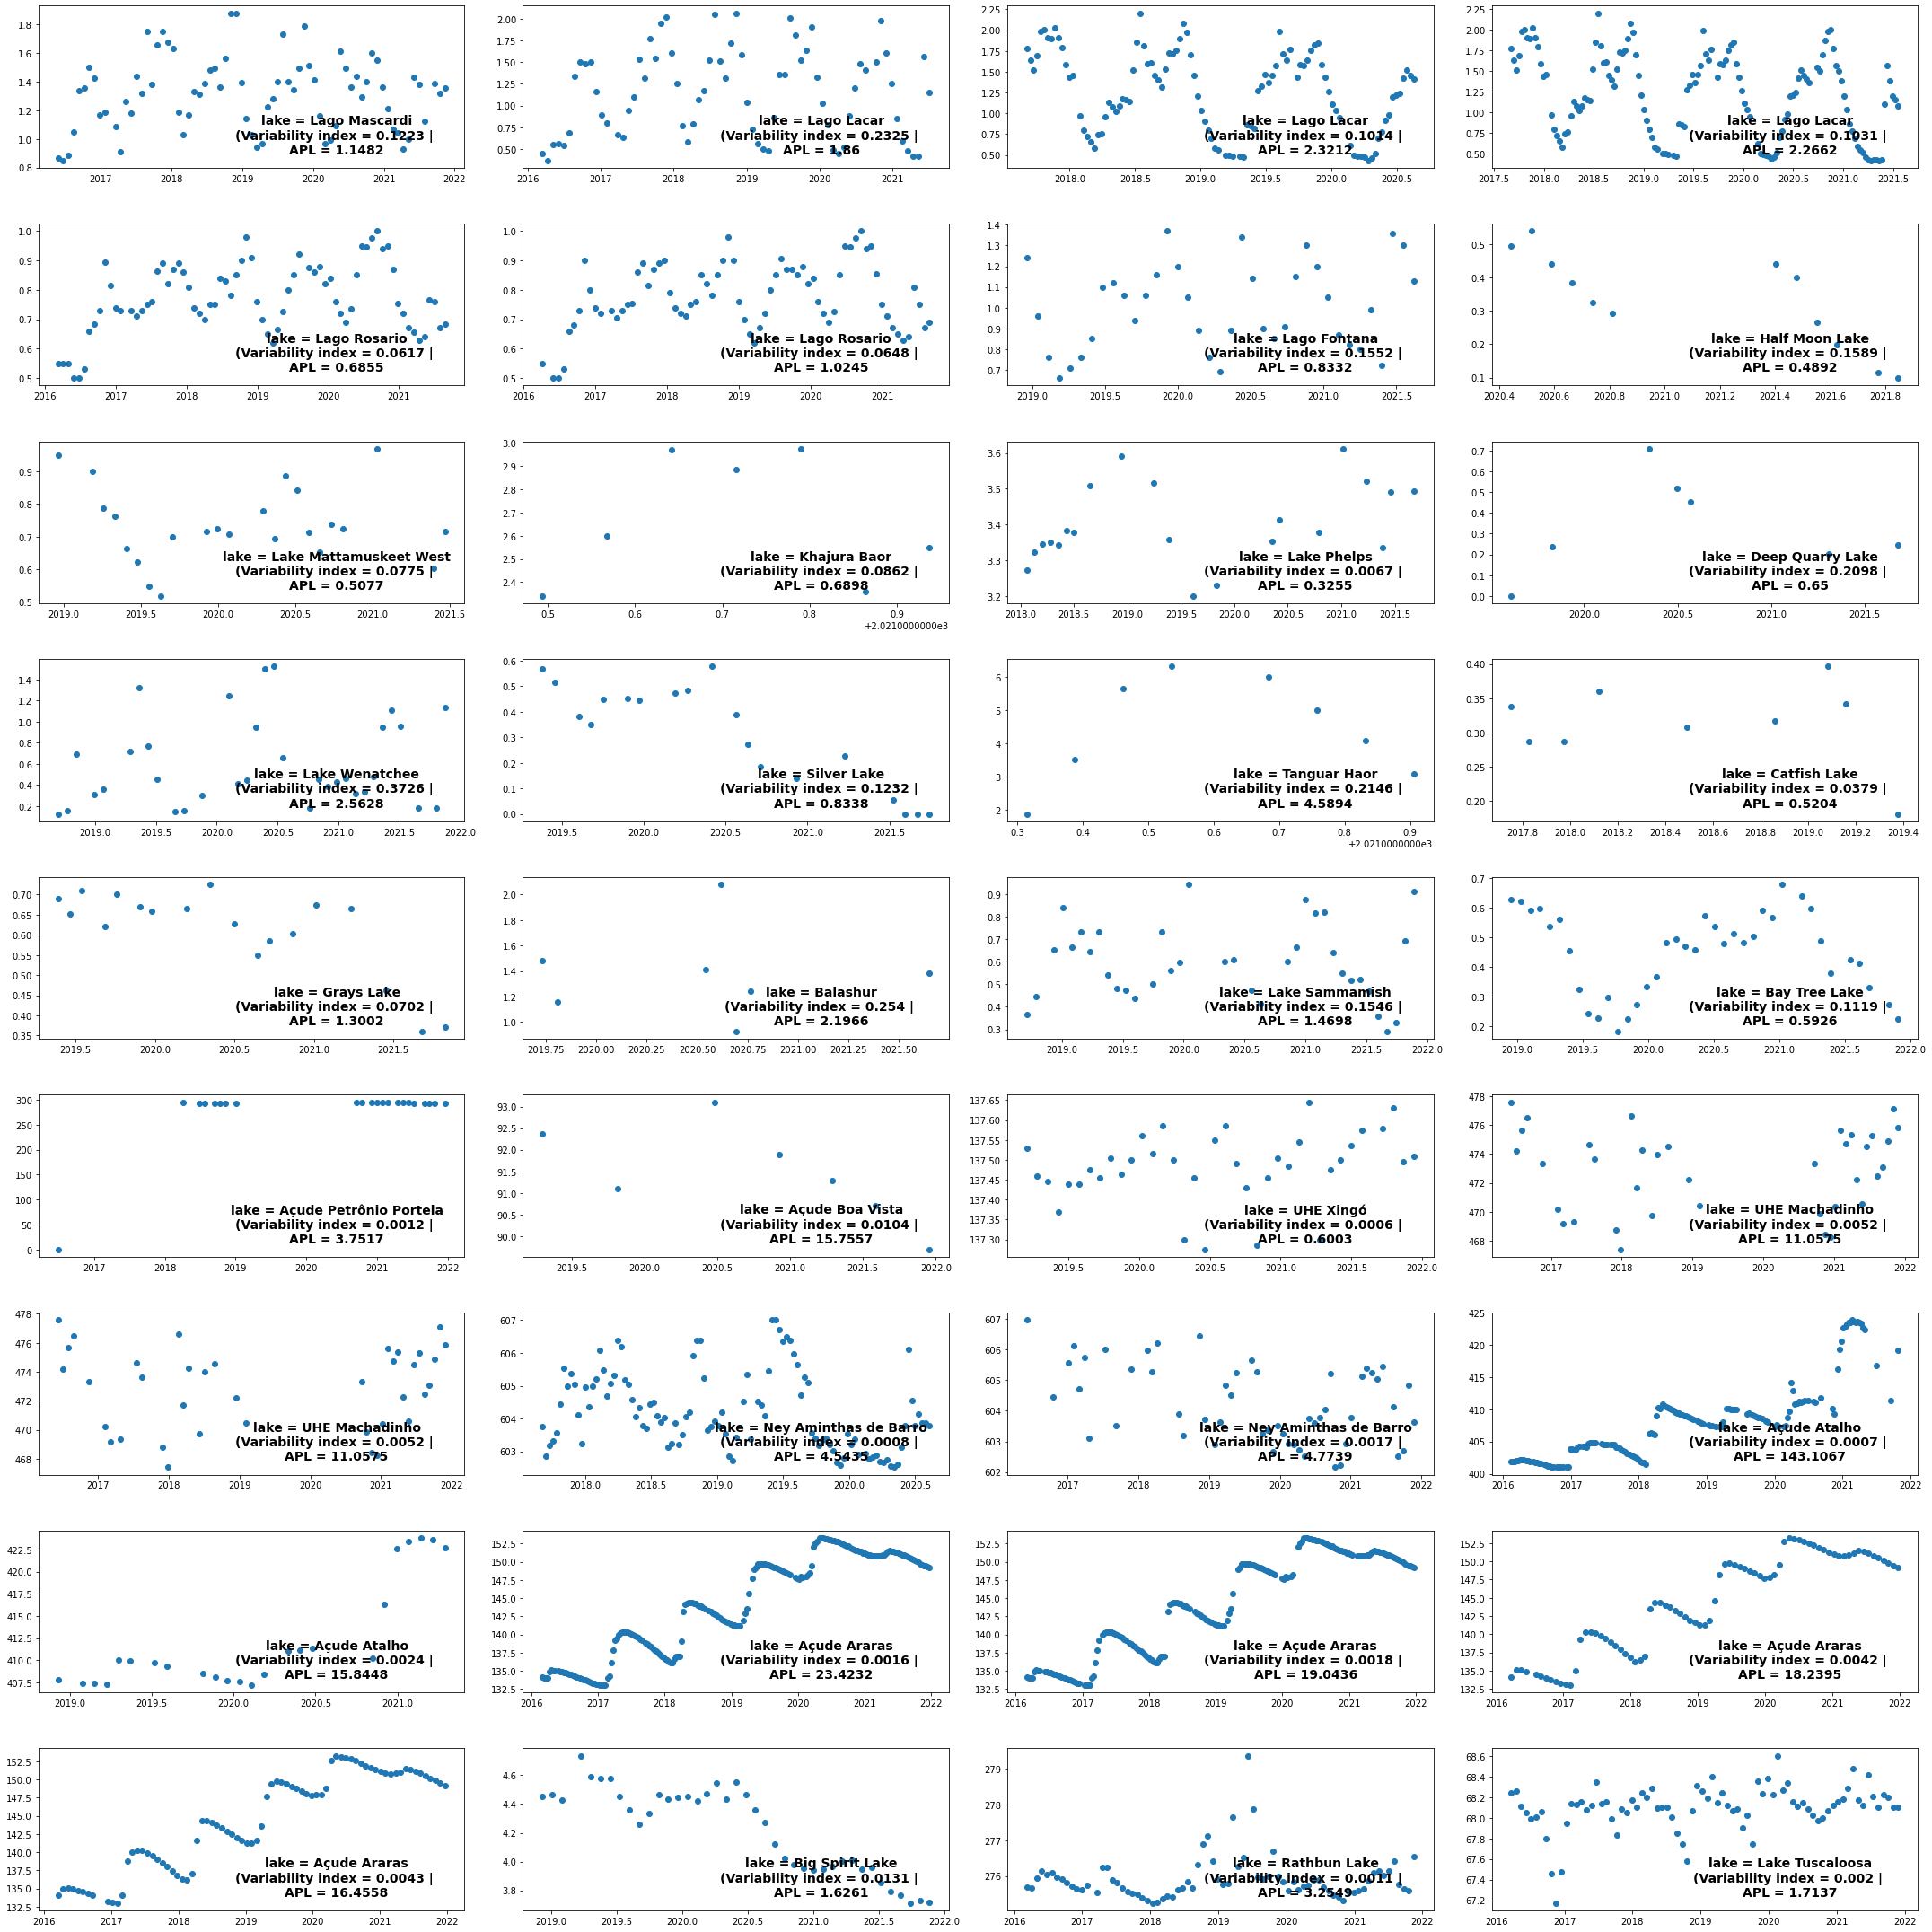

In [109]:
om='AlTiS_TimeSeries_Sentinel-3A_0562_S4128'
df_final_altis.columns


i=0
j=0
row_f=9
col_f=4
w=30
h=30
this_source='ALL'
fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
for om in df_final_altis['name_altis'].unique():
    df_val=df_final_altis.loc[df_final_altis['name_altis']==om]
    df_val
    df_metrics=df_cm.loc[df_cm['altis']==om]
    # ic(df_metrics)
    error_m_text='lake = '+df_metrics['lake_name'].iloc[0]+'\n(Variability index = '+str(np.round(df_metrics['rb_index'].iloc[0], decimals=4))+' | \n'+\
        'APL = '+str(np.round(df_metrics['APL'].iloc[0],decimals=4))#+' | n = '+str(df_metrics['n_obs'].iloc[0])+')'#+\
    # df_final_ground.columns
    # fig, ax = plt.subplots()
    # plt.subplot(row_f,col_f,nfig)
    #Observed Vs Estimates
    axs[i][j].scatter(df_val['decimal_y'],df_val['median_d_5'])#, linestyle=None, marker='o')
    fig.tight_layout(h_pad=3, w_pad=2)
    axs[i][j].text(0.7,0.2,error_m_text, fontsize=14,weight='bold',
                   horizontalalignment='center', verticalalignment='center', transform=axs[i][j].transAxes)
    if j>=col_f-1:
        j=0
        if i<=row_f-1:
            i=i+1
    else:
        j=j+1
    
# axs.legend()


In [100]:
df_cm.head()

,station,lake_name,altis,source,method,R,PR_pvalue,RHO,RHO_pvalue,NSF,...,ME,VE,number_obs,number_altis,cv_obs,sat_min_utcdate,sat_max_utcdate,grd_min_utcdate,grd_max_utcdate,rb_index
0,1824,Lago Mascardi,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,ARHN,Moving Window,0.938667,1.482146e-34,0.922702,4.145300e-31,0.881095,...,-8.265839e-14,0.008384,73,73,18.895559,2016-05-25 00:00:00+00:00,2021-11-13 00:00:00+00:00,2016-05-16,2021-11-23,0.122297
0,2028,Lago Lacar,AlTiS_TimeSeries_Sentinel-3A_0749_S4016,ARHN,Moving Window,0.973167,9.218785e-46,0.968995,1.258762e-43,0.946372,...,9.555736e-15,0.013263,71,71,43.290376,2016-03-12 00:00:00+00:00,2021-07-08 00:00:00+00:00,2016-03-02,2021-07-31,0.232501
0,2028,Lago Lacar,AlTiS_TimeSeries_Jason-3_0215_S4017,ARHN,Moving Window,0.886218,7.290972e-36,0.892176,5.476830e-37,0.784617,...,2.069392e-14,0.068505,104,104,38.312189,2017-09-03 00:00:00+00:00,2020-08-18 00:00:00+00:00,2017-08-24,2020-08-28,0.101381
0,2028,Lago Lacar,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,ARHN,Moving Window,0.905711,8.563824e-52,0.910803,2.469178e-53,0.820312,...,4.108478e-14,0.054292,136,136,40.680880,2017-09-03 00:00:00+00:00,2021-07-22 00:00:00+00:00,2017-08-24,2021-07-31,0.103105
0,2234,Lago Rosario,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,ARHN,Moving Window,0.650217,4.802968e-10,0.695427,8.646707e-12,0.417686,...,1.073905e-13,0.015484,73,73,15.292348,2016-03-08 00:00:00+00:00,2021-08-27 00:00:00+00:00,2016-02-27,2021-08-31,0.061688


In [156]:
pd.concat([df_ground_ts['gauge_id'],df_ground_ts['lake_name']]).unique()

array(['2464800', '6903880', '6604000', '1824', '2830', '1830', '2832',
       '2028', '2231', '2234', '2300', '2316', 'BLB2', 'BTN2', 'CFN2',
       'HMT2', 'MAB2', 'MCW2', 'MRP2', 'PAW2', 'PHN2', 'QUL2', 'RLH2',
       'SAW2', 'SLL2', 'SPA2', 'WEW2', 'YSL2', '19069', '19060', '19126',
       '12030', '12036', '12327', '12056', 'KHB2', 'TAB2', 'MTN2',
       'Tuscaloosa', 'Rathbun', 'Big Spirit', 'Mascardi', nan, 'Lacar',
       'Rosario', 'Fontana', 'Balashur', 'Bay Tree', 'Catfish',
       'Half Moon', 'McIntosh Lake', 'Manchar Lake', 'Pattison Lake',
       'Phelps', 'Deep Quarry', 'Russell Pond', 'Sammamish', 'Silver',
       'Snow Pond', 'Wenatchee', 'Grays', 'UHE Machadinho',
       'Ney Aminthas de Barro', 'UHE Xingó', 'Açude Araras',
       'Açude Atalho', 'Açude Petrônio Portela', 'Açude Boa Vista',
       'Khajura Baor', 'Tanguar Haor', 'Lake Mattamuskeet West'],
      dtype=object)

In [157]:
df_ground_ts.loc[df_ground_ts['lake_name']=='Phelps']

,gauge_id,source,decimal_y,height,date,year,month,day,hour,lake_name,doy,Hylak_id,SLIDE_snowIce,diff
339660,PHN2,LOCSS,2018.489155,3.398520,2018-06-28 13:17:00,2018,6,28,13,Phelps,179,9340.0,0.013407,NaN
339661,PHN2,LOCSS,2018.489155,3.398520,2018-06-28 13:17:00,2018,6,28,13,Phelps,179,9340.0,0.000091,NaN
339662,PHN2,LOCSS,2018.609132,3.468624,2018-08-11 08:12:22,2018,8,11,8,Phelps,223,NaN,NaN,NaN
339663,PHN2,LOCSS,2018.645320,3.508248,2018-08-24 13:02:44,2018,8,24,13,Phelps,236,9340.0,0.001295,NaN
339664,PHN2,LOCSS,2018.000000,3.230880,2018-01-01 00:01:00,2018,1,1,0,Phelps,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339957,PHN2,LOCSS,2022.018151,3.371088,2022-01-07 15:05:03,2022,1,7,15,Phelps,7,NaN,NaN,NaN
339958,PHN2,LOCSS,2022.100000,3.364992,2022-02-06 12:24:05,2022,2,6,12,Phelps,37,NaN,NaN,NaN
339959,PHN2,LOCSS,2022.220320,3.352800,2022-03-22 10:43:31,2022,3,22,10,Phelps,81,9340.0,0.000003,NaN
339960,PHN2,LOCSS,2022.253311,3.535680,2022-04-03 11:35:01,2022,4,3,11,Phelps,93,9340.0,0.000000,NaN


In [95]:
'../data/results/'+data_source+'_'+time_fig+'_all.png'

'../data/results/ICECV_20220526_08_50_all.png'

In [96]:
save_plot

True

In [111]:
df_cm

,station,altis,source,method,r2,NSF,RMSE,APL,ME,VE,number_obs,number_altis
0,1824,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,ARHN,Moving Window,0.938715,0.865378,0.091532,1.030000,8.262188e-14,0.008378,73,73
0,2028,AlTiS_TimeSeries_Sentinel-3A_0749_S4016,ARHN,Moving Window,0.973179,0.946392,0.115218,1.695000,-9.533845e-15,0.013275,71,71
0,2028,AlTiS_TimeSeries_Jason-3_0215_S4017,ARHN,Moving Window,0.886484,0.708670,0.261445,1.770000,-2.092664e-14,0.068353,104,104
0,2028,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,ARHN,Moving Window,0.906064,0.781520,0.232592,1.785000,-4.086764e-14,0.054099,136,136
0,2234,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,ARHN,Moving Window,0.652363,-0.115740,0.124084,0.500000,-1.074559e-13,0.015397,73,73
0,2234,AlTiS_TimeSeries_Sentinel-3A_0676_S4325,ARHN,Moving Window,0.560191,-1.378686,0.174566,0.500000,7.889214e-14,0.030473,72,72
0,2316,AlTiS_TimeSeries_Sentinel-3B_0020_S4492,ARHN,Moving Window,0.891357,0.773340,0.097216,0.710000,-9.203149e-14,0.009451,37,37
0,BTN2,AlTiS_TimeSeries_Sentinel-3B_0691_N3466,LOCSS,Moving Window,0.622740,0.177504,0.123829,0.496824,-4.959483e-16,0.015334,38,38
0,CFN2,AlTiS_TimeSeries_Sentinel-3A_0035_N3493,LOCSS,Moving Window,0.636623,-3.705776,0.123482,0.214884,3.164136e-15,0.015248,9,9
0,HMT2,AlTiS_TimeSeries_Sentinel-3A_0351_N5346,LOCSS,Moving Window,0.886224,0.752355,0.068395,0.442000,-1.042014e-13,0.004678,12,12


In [10]:
# #Do the linear interpolation to get the accuracies

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
path_name='../data/results/plots_it_'+time_fig+'/'

if save_plot:
    output_f=path_name
else:
    output_f=None

if start==0:
    df_final_altis=pd.DataFrame()
    df_final_ground=pd.DataFrame()
    df_cm=pd.DataFrame()

# #Read shapefile with all the coordinates and the id of the files

path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]


#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999

wse_ref='e'
ncolgeoid='geoid_01_median' #PENDING RAISE AND HANDLE THE EXCEPTION WHEN geoid column not found

    
i=1

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    ncolgeoid=row['ncolgeoid']
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
    if ncolgeoid!='No':
        #Call the function with geoid field and wse_type='e'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    else:
        #Call the function with geoid field and wse_type='g'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), st_id+' ground_st: '+str(not df_ground_st.empty)+
          ' df_altis: '+str(df_altis.shape)+' df_ground_st: '+str(df_ground_st.shape))
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]
        #if source !='RVBR':
        #     continue
            
       # df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        # Cut the time series to the same period the time series
        (df_altis_c, df_ground_c)=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
                                             date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=False, ndays=0)
       
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        #Recalculate date with dates in utc
        if source=='USGS':
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=False)
        else:
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_c=df_ground_c.sort_values(by=['decimal_y'])
        df_altis_c=df_altis_c.sort_values(by=['decimal_y'])
        
        df_ground_c['altis_d_1']=altis_name


        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_c['decimal_y'].to_numpy(), df_ground_c['height'].to_numpy(), 
                                          df_altis_c['decimal_y'].to_numpy(), df_altis_c['height'].to_numpy())
        
        
                #Create a output dataframe with the metrics
        cm_dict={'station':[st_id], 'altis':[altis_name], 'source':[source], 'method':['Linear Interpolation'],
                'R':[corr_alti_insi],'NSF':[ns_alti_insi],'RMSE':[rmse_alti_insi],'APL':[ampl_insi]}
        df_cmi=pd.DataFrame(cm_dict)
        
        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis_c), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_c), axis=0)
        
        df_cm=pd.concat((df_cm,df_cmi), axis=0)
        
        error_m_text='\nR: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'+\
        'Method: Linear interpolation'
        
        
        labels=altis_name
        labelg='Ground Obs '+source+' '+st_id
        labeli='Interp ground to altis'


        dfs=df_altis_c
        dfg=df_ground_c
        print('dimension ground altis', str(dfg.shape)+' '+str(dfs.shape))
        dic_intp={'decimal_y':df_altis_c['decimal_y'].to_numpy(), 'height':inh_2_altidy}

        dfi=pd.DataFrame(dic_intp)
        date_plot_fd='decimal_y'
        height_plot_fd='height'
        nfig=i
        if show_plot:
            p=plot_dev_mean(nfig,dfs, dfg, dfi, source, st_id, altis_name, date_plot_fd, height_plot_fd, labels, labelg, labeli, error_m_text, output_f)
            p.show()
            p.close()

        i=i+1
        
        
df_final_altis['method']='Linear interp'    
df_final_ground['method']='Linear interp'    



Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 1824 ground_st: True df_altis: (73, 8) df_ground_st: (8037, 9)
dimension ground altis (1998, 11) (73, 9)
Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 2028 ground_st: True df_altis: (77, 8) df_ground_st: (31001, 9)
dimension ground altis (1925, 11) (72, 9)
Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN 2028 ground_st: True df_altis: (104, 8) df_ground_st: (31001, 9)
dimension ground altis (1082, 11) (104, 9)
Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN 2028 ground_st: True df_altis: (157, 8) df_ground_st: (31001, 9)
dimension ground altis (1399, 11) (138, 9)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: True df_altis: (76, 8) df_ground_st: (26584, 9)
dimension ground altis (2003, 11) (73, 9)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: True df_altis: (75, 8) df_ground_st: (26584, 9)
dimension ground altis (1974, 11) (72

In [6]:
#Plot methods comparison metrics
import seaborn as sns
import matplotlib as plt
import pandas as pd

sns.set_style('white')
sns.set_context('notebook')#, font_scale=1.5)

# df=df_cm.copy()
df=pd.read_csv('../data/results/comparison_20220412_18_40.csv', sep=',')

df_t=pd.melt(df, id_vars=['station', 'altis', 'source', 'method','area_skm'], value_vars=['R','NSF','RMSE','APL'], ignore_index=True)
df_t['mission']=[x.split('_')[2] for x in df_t['altis']]
# df_t['to_plot_m']=[x.split('_')[2] for x in df_t['mission'] if x]
df_t.loc[df_t['mission'].isin(['Sentinel-3B','Jason-3']),'to_plot_m']=1
df_t.loc[~df_t['mission'].isin(['Sentinel-3B','Jason-3']),'to_plot_m']=0
df_t=df_t.loc[df_t['area_skm'].notna()]
# df['st_alti']
df_t.head()

,station,altis,source,method,area_skm,variable,value,mission,to_plot_m
0,1824,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,ARHN,Moving Window,36.62,r2,0.939,Sentinel-3A,0.0
1,2028,AlTiS_TimeSeries_Sentinel-3A_0749_S4016,ARHN,Moving Window,50.67,r2,0.973,Sentinel-3A,0.0
3,2028,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,ARHN,Moving Window,50.67,r2,0.906,Jason-3,1.0
4,2234,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,ARHN,Moving Window,8.90,r2,0.652,Sentinel-3A,0.0
5,2234,AlTiS_TimeSeries_Sentinel-3A_0676_S4325,ARHN,Moving Window,8.90,r2,0.560,Sentinel-3A,0.0


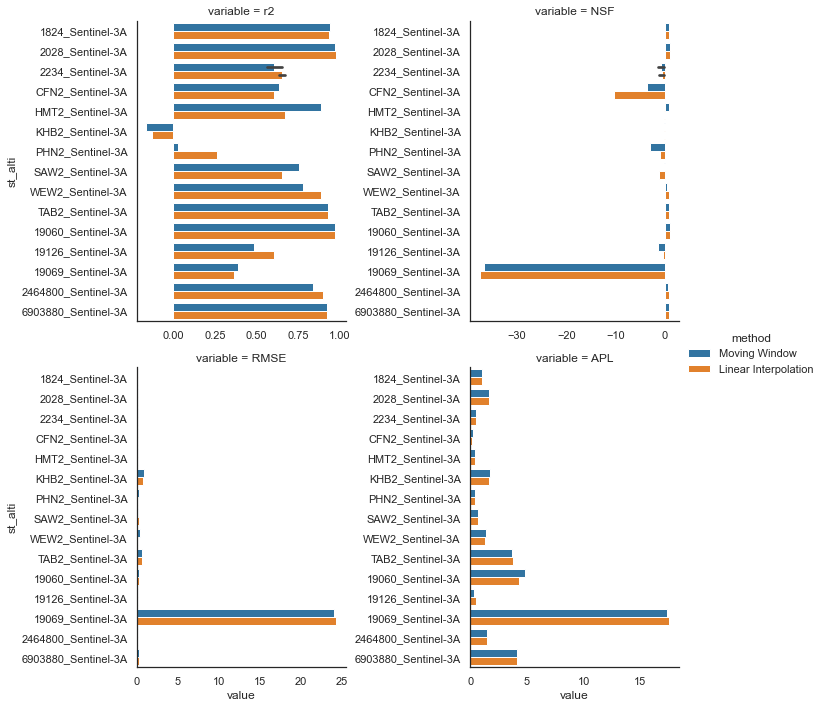

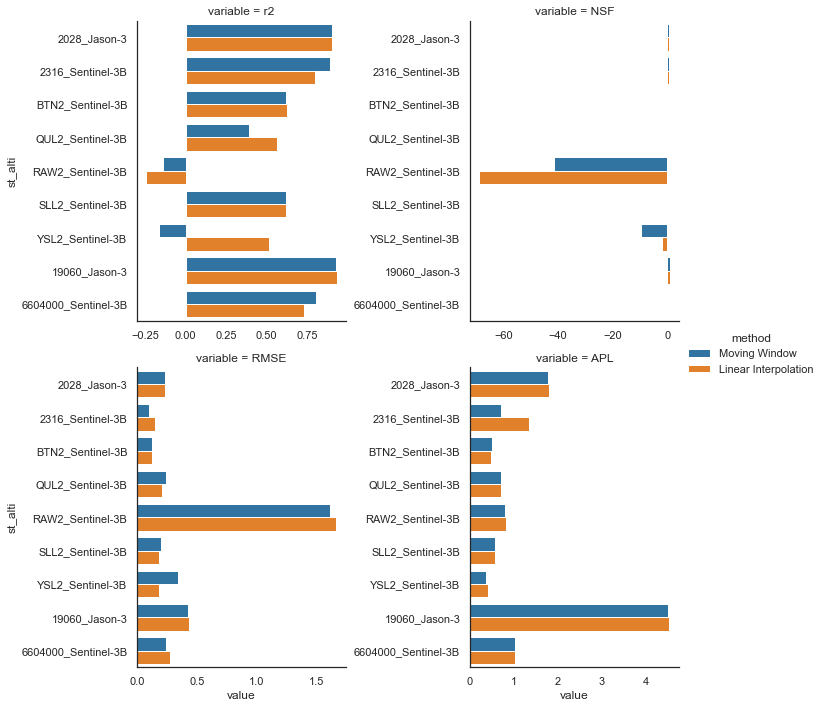

In [7]:
for s in df_t['to_plot_m'].unique():
    df=df_t.loc[df_t['to_plot_m']==s].copy()
    df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['mission'], axis=1) #LO QUE NECESITA ES ESTO
    x_fd='value'
    y_fd='st_alti'
    hue='method'
    col='variable'
    row='variable'#'source'
    g = sns.catplot(data=df,sharex=False,sharey=False,
                x=x_fd, y=y_fd,
                hue=hue, #col=col,
                col=row, col_wrap=2,
                kind="bar",
                dodge=True)
    #                height=4, aspect=.7)
    g
    del df

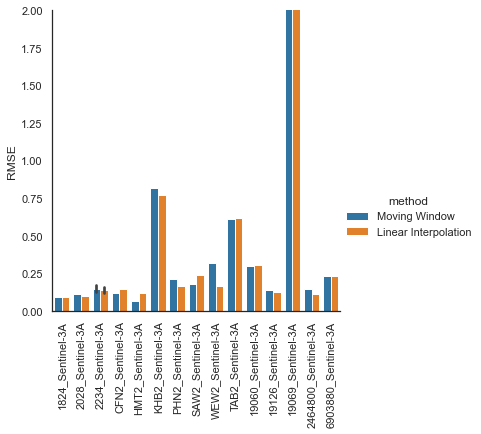

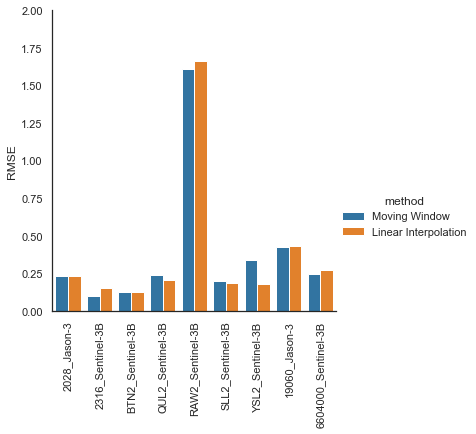

In [15]:
for s in df_t['to_plot_m'].unique():
    df=df_t.loc[df_t['to_plot_m']==s].copy()
    df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['mission'], axis=1) #LO QUE NECESITA ES ESTO
    df=df.loc[df['variable']=='RMSE']
    x_fd='st_alti'
    y_fd='value'
    hue='method'
    #col='variable'
    #row='variable'#'source'
    g = sns.catplot(data=df,sharex=False,sharey=False,
                x=x_fd, y=y_fd,
                hue=hue, #col=col,
     #           col=row, col_wrap=2,
                kind="bar",
                dodge=True)
    #                height=4, aspect=.7)
    g
    g.set_xticklabels(rotation=90)
    g.set_axis_labels(x_var='',y_var='RMSE')
    g.set(ylim=(0,2))
    del df

  station                                      altis source         method  \
0    1824    AlTiS_TimeSeries_Sentinel-3A_0562_S4128   ARHN  Moving Window   
1    2028    AlTiS_TimeSeries_Sentinel-3A_0749_S4016   ARHN  Moving Window   
3    2028  AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017   ARHN  Moving Window   
4    2234    AlTiS_TimeSeries_Sentinel-3A_0635_S4324   ARHN  Moving Window   
5    2234    AlTiS_TimeSeries_Sentinel-3A_0676_S4325   ARHN  Moving Window   

   area_skm variable  value      mission           st_alti  
0     36.62       r2  0.939  Sentinel-3A  1824_Sentinel-3A  
1     50.67       r2  0.973  Sentinel-3A  2028_Sentinel-3A  
3     50.67       r2  0.906      Jason-3      2028_Jason-3  
4      8.90       r2  0.652  Sentinel-3A  2234_Sentinel-3A  
5      8.90       r2  0.560  Sentinel-3A  2234_Sentinel-3A  


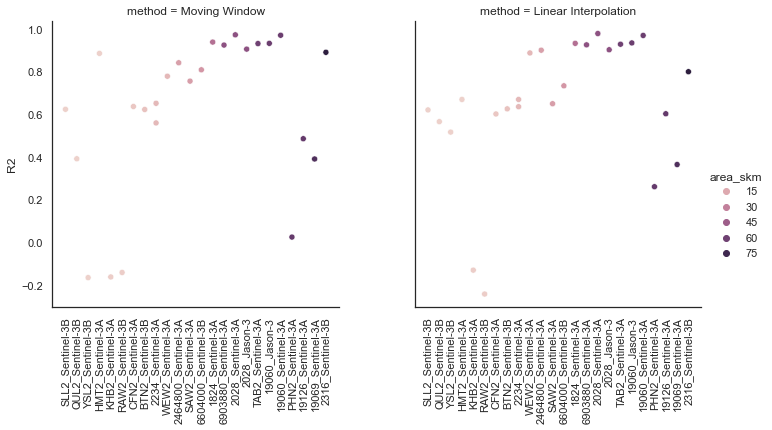

In [3]:
df=df_t.copy()
df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['mission'], axis=1) #LO QUE NECESITA ES ESTO
# df=df.loc[df['variable'].isin(['R', 'RMSE'])]
df=df.loc[df['variable']=='R']
# sns.set(rc = {'figure.figsize':(10,2)})
sns.set_style('white')

print(df.head())
df=df.sort_values(by=['area_skm'])
x_fd='st_alti'
y_fd='value'
hue='area_skm'#'method'
col='variable'
row='method'#'source'
# for i in ['r2', 'RMSE']:
# df=df.loc[df[col]==i]
g = sns.relplot(data=df,#sharex=False,sharey=False,
        x=x_fd, y=y_fd,
        hue=hue, col=row,
        #col=row,# col_wrap=2,
        kind="scatter")#,
            #join=False)#,
        #dodge=True)
#                height=4, aspect=.7)
g
g.set_xticklabels(rotation=90)
g.set_axis_labels(x_var='', y_var='R')
# g.set(ylim=(0,2))
del df
# g = sns.catplot(data=df,sharex=False,sharey=False,
#             x=x_fd, y=y_fd,
#             hue=hue, #row=row,
#  #           col=row, col_wrap=2,
#             kind="point",
#                 join=False)#,
#             #dodge=True)
# #                height=4, aspect=.7)
# g
# g.set_xticklabels(rotation=90)
# del df

In [ ]:
for s in df_t['source'].unique():
    df=df_t.loc[df_t['source']==s].copy()
    df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['altis'][17:], axis=1) #LO QUE NECESITA ES ESTO
    x_fd='value'
    y_fd='st_alti'
    hue='method'
    col='variable'
    row='variable'#'source'
    g = sns.catplot(data=df,sharex=False,sharey=False,
                x=x_fd, y=y_fd,
                hue=hue, #col=col,
                col=row, col_wrap=2,
                kind="bar",
                dodge=True)
    #                height=4, aspect=.7)
    g
    del df

In [ ]:
# #read all altiss 


# import geoplot as gplt
# #WRITE AS FUNCTIONS TO MOVE LATER
# #Read shapefile with all the coordinates and the id of the files
#path= '/home/angelica/Dropbox/Research/LOCSS/Denis_Sylvain/15_L_Altis_20220318/lonlat_vs_altis_ed.shp' When it is a shape file
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]
# print(altis_shp.shape)
# print(altis_w_gts_shp.shape)
# print(altis_w_gts_shp.columns)
# print(altis_csv.shape)
# print(altis_w_gts_csv.shape)
# print(altis_w_gts_csv.columns)

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
i=1
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    
    df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        source=df_ground_st['source'].iloc[0]
        if source=='RVBR':
            continue
        #Convert time in df_gts_st to UTC
        
        df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        #print(df_ground_st.head(), st_id)
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        if source=='USGS':
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=False)
        else:
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st=df_ground_st.sort_values(by=['decimal_y'])
        df_ground_st['altis_d_1']=altis_name

        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_st), axis=0)

        #Get the max and mins
        altis_min=df_altis['decimal_y'].min()
        ground_min=df_ground_st['decimal_y'].min()
        altis_max=df_altis['decimal_y'].max()
        ground_max=df_ground_st['decimal_y'].max()
        # print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        # print('\nAltis_max Ground_max: ',[altis_max, ground_max])
        #print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        if altis_min>ground_min:
            df_ground_plot=df_ground_st.loc[(df_ground_st['decimal_y']>=altis_min)]#&(df_ground_st['decimal_y']<altis_max)]
            df_altis_plot=df_altis
        else:
            df_ground_plot=df_ground_st
            df_altis_plot=df_altis.loc[(df_altis['decimal_y']>=ground_min)]#&(df_ground_st['decimal_y']<altis_max)]


        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_plot['decimal_y'].to_numpy(), df_ground_plot['height'].to_numpy(), 
                                          df_altis_plot['decimal_y'].to_numpy(), df_altis_plot['height'].to_numpy())
        
        
        error_m_text='\nR: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'



        plt.figure(i, figsize=(20, 6))
        gplot=plt.plot(df_ground_plot['decimal_y'], 
                       df_ground_plot['height'], '-go', markersize=1.5, label='Ground Obs '+st_id)
        iplot=plt.plot(df_altis_plot['decimal_y'].to_numpy(), 
                        inh_2_altidy, '--ks', markersize=3, label='Interp ground to altis')
        #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        plt.xlabel('Time (decimal year)', size=15, weight='bold')
        plt.ylabel('Water elevation (m)', size=15, weight='bold')
        plt.grid('on')
        plt.legend()
        plt.title('Water elevation (m)', size=15,
                  weight='bold')
        plt.savefig('../data/plots/'+source+'_ground_interp_'+st_id+'_vs_'+altis_name+'.png',
                     bbox_inches='tight')
        i=i+1
        
        
    
    #['gauge_id','source'
    
# def open_match__plot_station_altis(g_path,altis_name, st_id, df_gts, altis_date_fd, altis_height_fd, nodataalti=-9999):


In [134]:
df_altis_plot

,decimal_y,height,year,month,day,hour,name_altis,ground_st_1
0,2016.183479,275.212348,2016,3,8,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
1,2016.257250,275.298792,2016,4,4,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
2,2016.331020,275.150594,2016,5,1,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
3,2016.404791,275.351242,2016,5,28,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
4,2016.478561,275.598305,2016,6,24,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
...,...,...,...,...,...,...,...,...
72,2021.578505,275.578580,2021,7,31,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
73,2021.652477,274.932534,2021,8,27,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
74,2021.726450,274.997760,2021,9,23,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
75,2021.800422,274.833224,2021,10,20,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880


In [48]:
df1=go.read_ground_data('LOCSS', station_id=lc_lakes)
# df.shape
# df_locss_filtered=df.loc[df['gauge_id'].isin(lc_lakes)]
# df_locss_filtered.shape
x=df1['gauge_id'].unique()
for a in x:
    print(df1.loc[df1['gauge_id']==a].shape)

(536, 24)
(53, 24)
(170, 24)
(256, 24)
(109, 24)
(393, 24)


In [13]:
df_arhn.head(3)

,date,height,source,gauge_id,year,month,day,hour,decimal_y
0,2010-03-01 12:00:00,2.30,ARHN,2830,2010,3,1,12,2010.163014
1,2010-03-02 12:00:00,2.30,ARHN,2830,2010,3,2,12,2010.165753
2,2010-03-03 13:00:00,2.31,ARHN,2830,2010,3,3,12,2010.168493


In [14]:
df_usgs.head(3)

,Unnamed: 0,agency_cd,gauge_id,date,height,X_00065_00003_cd,source,year,month,day,hour,decimal_y
0,1,USGS,2464800,2002-07-04,223.73,A,USGS,2002,7,4,12,2002.505479
1,2,USGS,2464800,2002-07-05,223.66,A,USGS,2002,7,5,12,2002.508219
2,3,USGS,2464800,2002-07-06,223.61,A,USGS,2002,7,6,12,2002.510959
